# Multivariate Analysis

In [1]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\df_nadal_clean.csv',sep=',')

In [3]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [4]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_FR','AU_355_FL','AT_X','AT_Z']], df[['L/V_FL']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


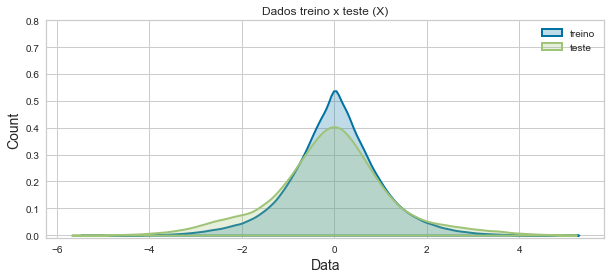

In [5]:
plt.figure(figsize=(10,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])
plt.legend(loc='upper right')

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


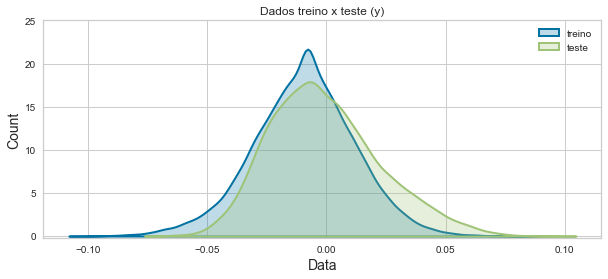

In [6]:
plt.figure(figsize=(10,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Dados treino x teste (y)")
plt.ylim([-0.2,25])
plt.legend(loc='upper right')

A distribuição parece ser representativa, podemos seguir em frente

In [7]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


In [8]:
study_rf = joblib.load("study_RandomForest_B.pkl")
study_ab = joblib.load("study_AdaBost_B.pkl")
study_en = joblib.load("study_ElasticNet_B.pkl")
study_xgb = joblib.load("study_XGBoost.pkl")


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=36, max_features=5, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=375,
                      random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000

 17%|█▋        | 1/6 [00:00<00:00,  9.29it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\1229660262.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 33%|███▎      | 2/6 [01:35<03:43, 55.86s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|█████     | 3/6 [07:38<09:49, 196.53s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [07:56<

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Obtaining feature importance - 100%
CPU times: total: 20min 41s
Wall time: 8min 5s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

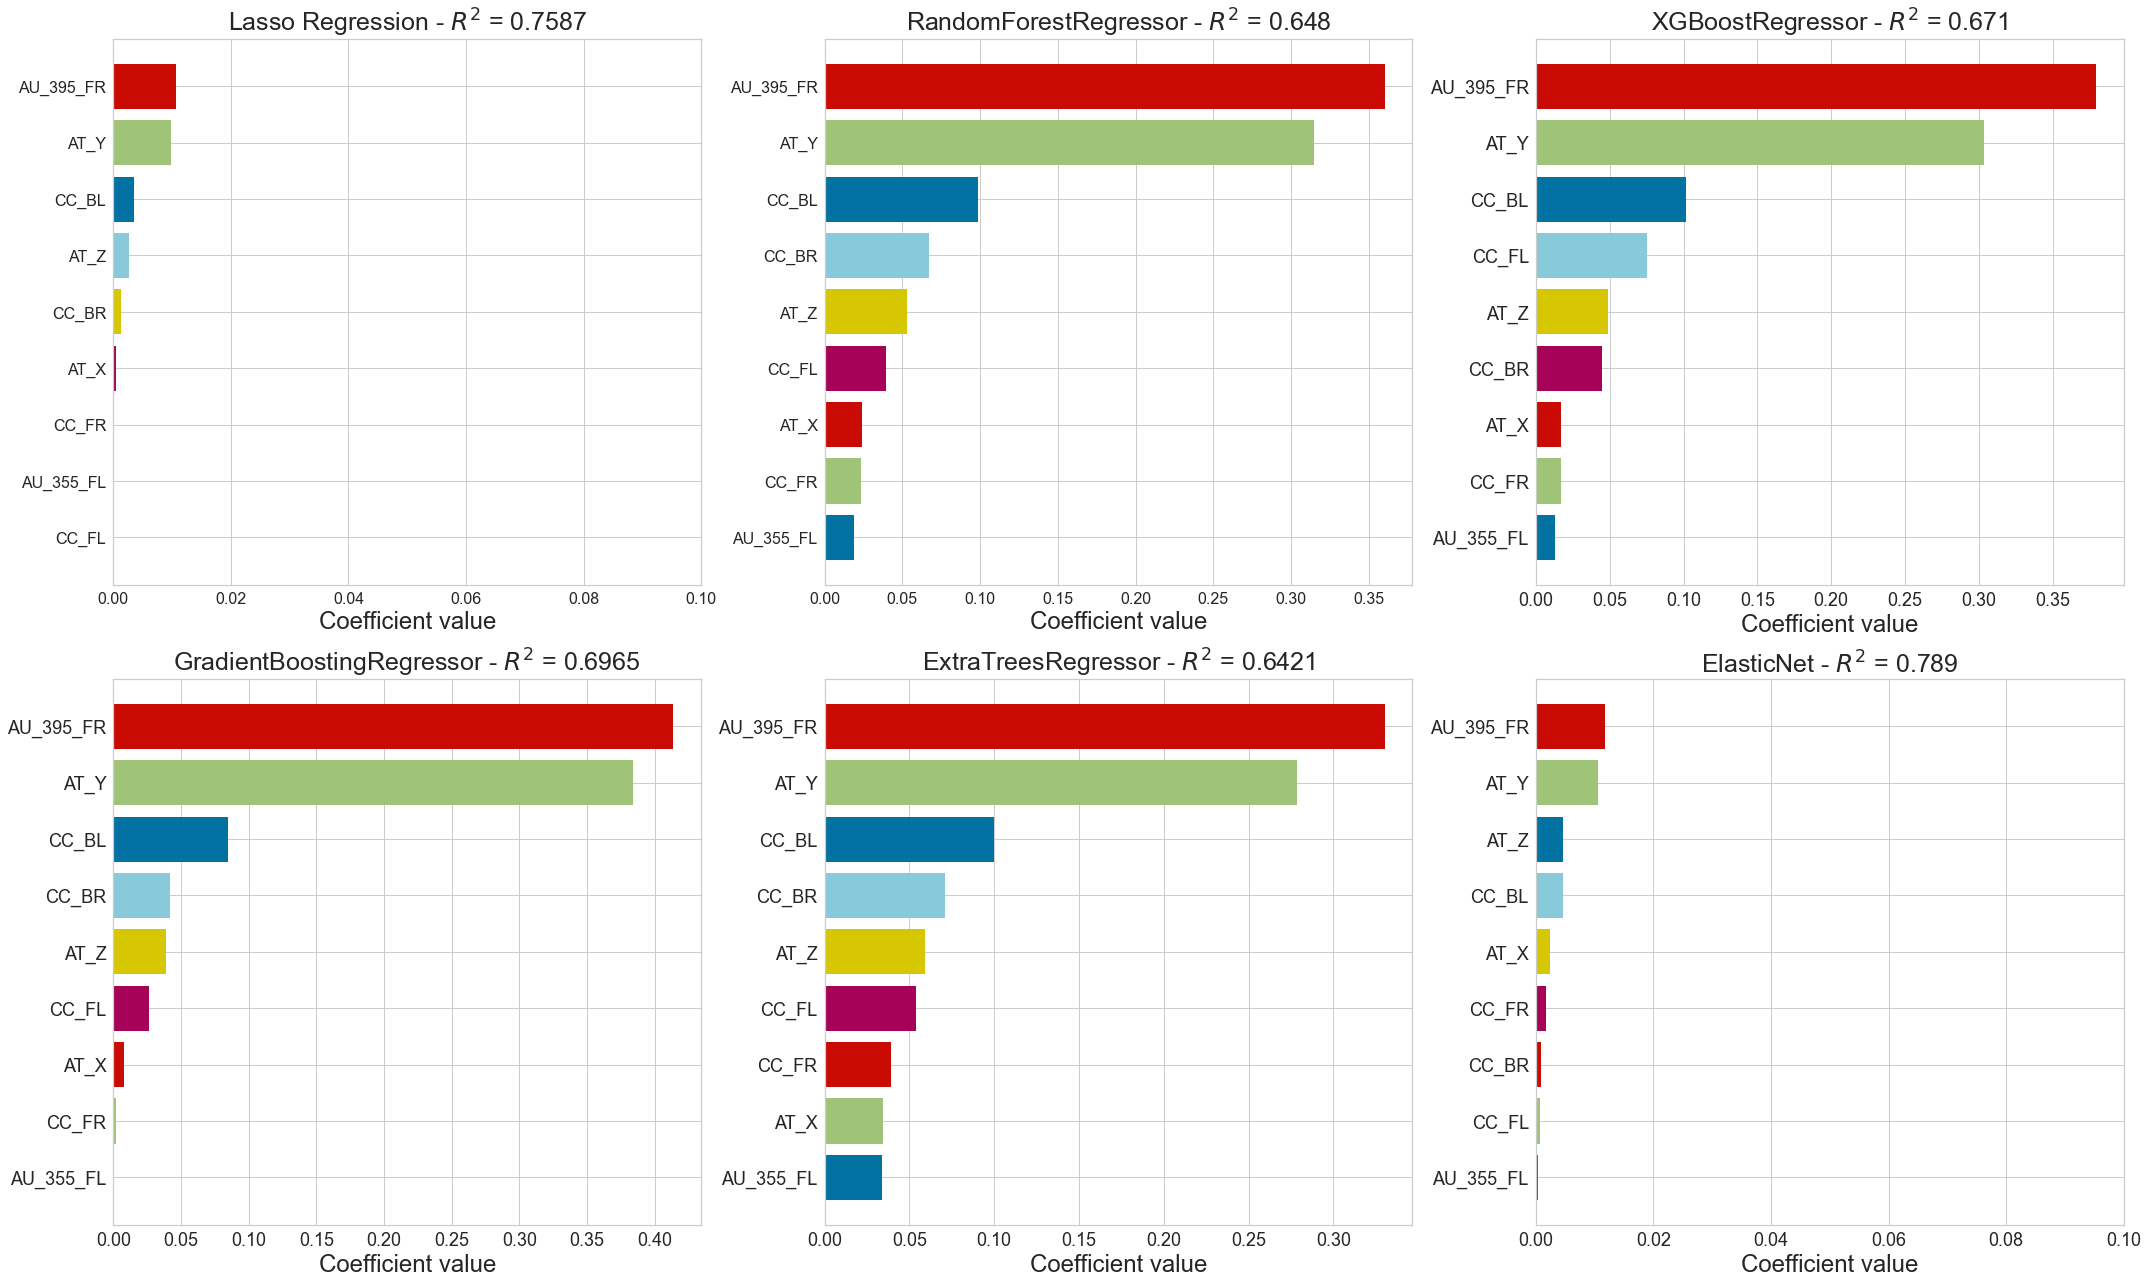

In [9]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [10]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [11]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-05 19:34:18,269] A new study created in memory with name: no-name-b791614f-4458-457e-83c7-cea6845c8a0c


In [12]:
study.optimize(objective, n_trials=20,show_progress_bar=True)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:34:43,027] Trial 0 finished with value: 0.6548385632433258 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:36:02,171] Trial 1 finished with value: 0.6535987139292114 and parameters: {'n_estimators': 850, 'max_depth': 20, 'min_samples_leaf': 17, 'min_samples_split': 14, 'max_features': 6}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:36:38,854] Trial 2 finished with value: 0.6515454959531114 and parameters: {'n_estimators': 275, 'max_depth': 34, 'min_samples_leaf': 5, 'min_samples_split': 16, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:37:50,726] Trial 3 finished with value: 0.6539976456131155 and parameters: {'n_estimators': 600, 'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 20, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:38:37,773] Trial 4 finished with value: 0.6466770793908807 and parameters: {'n_estimators': 550, 'max_depth': 22, 'min_samples_leaf': 10, 'min_samples_split': 14, 'max_features': 4}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:39:54,189] Trial 5 finished with value: 0.6534829029480176 and parameters: {'n_estimators': 625, 'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 3, 'max_features': 6}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:41:14,536] Trial 6 finished with value: 0.6479572880149485 and parameters: {'n_estimators': 900, 'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 16, 'max_features': 4}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:42:57,870] Trial 7 finished with value: 0.6529312848917567 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 18, 'min_samples_split': 15, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:44:03,753] Trial 8 finished with value: 0.6452554389246385 and parameters: {'n_estimators': 950, 'max_depth': 48, 'min_samples_leaf': 18, 'min_samples_split': 8, 'max_features': 4}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:44:17,236] Trial 9 finished with value: 0.6484679688676378 and parameters: {'n_estimators': 200, 'max_depth': 38, 'min_samples_leaf': 13, 'min_samples_split': 19, 'max_features': 4}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:44:21,801] Trial 10 finished with value: 0.23471160415838455 and parameters: {'n_estimators': 400, 'max_depth': 2, 'min_samples_leaf': 13, 'min_samples_split': 8, 'max_features': 3}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:45:06,316] Trial 11 finished with value: 0.6504937185198086 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 9, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:46:31,222] Trial 12 finished with value: 0.6515731156223924 and parameters: {'n_estimators': 775, 'max_depth': 32, 'min_samples_leaf': 7, 'min_samples_split': 20, 'max_features': 5}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:47:49,981] Trial 13 finished with value: 0.6532903658629687 and parameters: {'n_estimators': 500, 'max_depth': 42, 'min_samples_leaf': 12, 'min_samples_split': 4, 'max_features': 7}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:48:06,394] Trial 14 finished with value: 0.5455480856682299 and parameters: {'n_estimators': 375, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 11, 'max_features': 2}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:49:36,807] Trial 15 finished with value: 0.6529383403301336 and parameters: {'n_estimators': 750, 'max_depth': 28, 'min_samples_leaf': 15, 'min_samples_split': 6, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:50:14,232] Trial 16 finished with value: 0.6506561766999219 and parameters: {'n_estimators': 200, 'max_depth': 38, 'min_samples_leaf': 5, 'min_samples_split': 11, 'max_features': 8}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:51:07,256] Trial 17 finished with value: 0.6284622894801668 and parameters: {'n_estimators': 1000, 'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 18, 'max_features': 2}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:51:47,244] Trial 18 finished with value: 0.6518105855772724 and parameters: {'n_estimators': 475, 'max_depth': 44, 'min_samples_leaf': 20, 'min_samples_split': 6, 'max_features': 5}. Best is trial 0 with value: 0.6548385632433258.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-05 19:52:24,532] Trial 19 finished with value: 0.6503630175990827 and parameters: {'n_estimators': 325, 'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 12, 'max_features': 7}. Best is trial 0 with value: 0.6548385632433258.
Accuracy: 0.6548385632433258
Best hyperparameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 8}


In [13]:
joblib.dump(study, "study_RandomForest_FL.pkl")

['study_RandomForest_FL.pkl']

In [14]:
study.best_trial

FrozenTrial(number=0, values=[0.6548385632433258], datetime_start=datetime.datetime(2022, 12, 5, 19, 34, 18, 538437), datetime_complete=datetime.datetime(2022, 12, 5, 19, 34, 43, 26526), params={'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 11, 'min_samples_split': 10, 'max_features': 8}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=25), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [15]:
optuna.visualization.plot_optimization_history(study)

In [16]:
optuna.visualization.plot_slice(study)

### Extra-Trees Regressor

In [17]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    
        
    param = {
        'n_estimators': trial.suggest_int('n_estimators',200,800,25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10,1),
        'random_state': 2020,
        #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',1,1000,25),
       
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.2,step=0.01),
    
    }
    
    model = ExtraTreesRegressor(**param)    
  
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ext = optuna.create_study(direction='maximize')

[I 2022-12-05 19:52:29,000] A new study created in memory with name: no-name-4666f973-b54b-4725-9bf9-ccba9a2e8b36


In [18]:
study_ext.optimize(objective, n_trials=100,show_progress_bar=True)

trial_ext = study_ext.best_trial

print('Accuracy: {}'.format(trial_ext.value))
print("Best hyperparameters: {}".format(trial_ext.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:52:32,565] Trial 0 finished with value: 0.23342850436702156 and parameters: {'n_estimators': 250, 'max_depth': 4, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.23342850436702156.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:52:34,664] Trial 1 finished with value: 0.2678180363511299 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.09}. Best is trial 1 with value: 0.2678180363511299.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:52:43,570] Trial 2 finished with value: 0.26325240111007253 and parameters: {'n_estimators': 700, 'max_depth': 6, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.09}. Best is trial 1 with value: 0.2678180363511299.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:52:48,267] Trial 3 finished with value: 0.2177282574973608 and parameters: {'n_estimators': 450, 'max_depth': 4, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.11}. Best is trial 1 with value: 0.2678180363511299.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:03,768] Trial 4 finished with value: 0.4988858105418428 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.02}. Best is trial 4 with value: 0.4988858105418428.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:13,012] Trial 5 finished with value: 0.2889034153142773 and parameters: {'n_estimators': 725, 'max_depth': 12, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.08}. Best is trial 4 with value: 0.4988858105418428.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:20,025] Trial 6 finished with value: 0.2639332380091335 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.09}. Best is trial 4 with value: 0.4988858105418428.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:27,530] Trial 7 finished with value: 0.4115950479823628 and parameters: {'n_estimators': 350, 'max_depth': 8, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.04}. Best is trial 4 with value: 0.4988858105418428.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:30,179] Trial 8 finished with value: 0.12471128469967618 and parameters: {'n_estimators': 350, 'max_depth': 2, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.16}. Best is trial 4 with value: 0.4988858105418428.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:34,145] Trial 9 finished with value: 0.13306841351886733 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.16}. Best is trial 4 with value: 0.4988858105418428.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:53:50,402] Trial 10 finished with value: 0.551756934622508 and parameters: {'n_estimators': 550, 'max_depth': 14, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.01}. Best is trial 10 with value: 0.551756934622508.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:54:30,639] Trial 11 finished with value: 0.6505471052883008 and parameters: {'n_estimators': 575, 'max_depth': 14, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}. Best is trial 11 with value: 0.6505471052883008.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:55:24,529] Trial 12 finished with value: 0.6513015448718587 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}. Best is trial 12 with value: 0.6513015448718587.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:56:24,205] Trial 13 finished with value: 0.6547521650530916 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:56:38,341] Trial 14 finished with value: 0.4135422682064792 and parameters: {'n_estimators': 775, 'max_depth': 16, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.04}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:56:49,435] Trial 15 finished with value: 0.41106535522955023 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.04}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:56:54,305] Trial 16 finished with value: 0.08202981890049876 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.2}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:57:02,818] Trial 17 finished with value: 0.3438199785069934 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.06}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:57:19,201] Trial 18 finished with value: 0.4950753909483754 and parameters: {'n_estimators': 725, 'max_depth': 18, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:57:38,522] Trial 19 finished with value: 0.6173029948286517 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:57:48,343] Trial 20 finished with value: 0.3438199785069934 and parameters: {'n_estimators': 650, 'max_depth': 14, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.06}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:58:34,169] Trial 21 finished with value: 0.6505471052883008 and parameters: {'n_estimators': 575, 'max_depth': 14, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:58:49,048] Trial 22 finished with value: 0.49898114874341726 and parameters: {'n_estimators': 500, 'max_depth': 18, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.02}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:01,942] Trial 23 finished with value: 0.45105332964680234 and parameters: {'n_estimators': 600, 'max_depth': 14, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.03}. Best is trial 13 with value: 0.6547521650530916.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:31,469] Trial 24 finished with value: 0.6566011144025415 and parameters: {'n_estimators': 375, 'max_depth': 16, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.0}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:36,747] Trial 25 finished with value: 0.3500482646079477 and parameters: {'n_estimators': 350, 'max_depth': 18, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.06}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:40,139] Trial 26 finished with value: 0.18607092011232929 and parameters: {'n_estimators': 400, 'max_depth': 16, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.13}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:44,828] Trial 27 finished with value: 0.38022194851060565 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.05}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:56,144] Trial 28 finished with value: 0.5514344835328913 and parameters: {'n_estimators': 400, 'max_depth': 12, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.01}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 19:59:58,228] Trial 29 finished with value: 0.20055787471531716 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.13}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:00:04,565] Trial 30 finished with value: 0.4519035547591367 and parameters: {'n_estimators': 275, 'max_depth': 8, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.03}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:00:45,187] Trial 31 finished with value: 0.6505303950898664 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:02:02,094] Trial 32 finished with value: 0.6544681035158877 and parameters: {'n_estimators': 675, 'max_depth': 18, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.0}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:02:25,830] Trial 33 finished with value: 0.5511948586359914 and parameters: {'n_estimators': 750, 'max_depth': 20, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.01}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:02:44,462] Trial 34 finished with value: 0.49677312793049266 and parameters: {'n_estimators': 675, 'max_depth': 18, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.02}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:03:01,307] Trial 35 finished with value: 0.4515977113939702 and parameters: {'n_estimators': 800, 'max_depth': 16, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.03}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:03:23,700] Trial 36 finished with value: 0.5519939859806298 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:03:34,968] Trial 37 finished with value: 0.3187790535620061 and parameters: {'n_estimators': 750, 'max_depth': 12, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.07}. Best is trial 24 with value: 0.6566011144025415.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:04:30,284] Trial 38 finished with value: 0.6569150679218346 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:04:47,900] Trial 39 finished with value: 0.49639650227044474 and parameters: {'n_estimators': 700, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.02}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:04:54,274] Trial 40 finished with value: 0.24084932408990167 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.1}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:05:29,638] Trial 41 finished with value: 0.6559895182279398 and parameters: {'n_estimators': 525, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:05:44,128] Trial 42 finished with value: 0.5524170271496592 and parameters: {'n_estimators': 550, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:05:53,333] Trial 43 finished with value: 0.45054991210637474 and parameters: {'n_estimators': 475, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.03}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:22,292] Trial 44 finished with value: 0.6561696261856474 and parameters: {'n_estimators': 400, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:28,766] Trial 45 finished with value: 0.4126153234485094 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.04}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:38,890] Trial 46 finished with value: 0.5521026715831405 and parameters: {'n_estimators': 375, 'max_depth': 18, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.01}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:44,276] Trial 47 finished with value: 0.3900891414510489 and parameters: {'n_estimators': 450, 'max_depth': 4, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:50,409] Trial 48 finished with value: 0.5002689377185081 and parameters: {'n_estimators': 325, 'max_depth': 16, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.02}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:52,750] Trial 49 finished with value: 0.07559380067956911 and parameters: {'n_estimators': 425, 'max_depth': 18, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.2}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:06:59,939] Trial 50 finished with value: 0.4318440616338607 and parameters: {'n_estimators': 475, 'max_depth': 6, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.03}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:07:35,277] Trial 51 finished with value: 0.6559895182279398 and parameters: {'n_estimators': 525, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:08:11,540] Trial 52 finished with value: 0.6562675848021077 and parameters: {'n_estimators': 525, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:08:29,042] Trial 53 finished with value: 0.5524009954718706 and parameters: {'n_estimators': 550, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:09:04,579] Trial 54 finished with value: 0.6562675848021077 and parameters: {'n_estimators': 525, 'max_depth': 20, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:09:16,958] Trial 55 finished with value: 0.4986788485082454 and parameters: {'n_estimators': 525, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.02}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:09:20,336] Trial 56 finished with value: 0.10442458275953981 and parameters: {'n_estimators': 575, 'max_depth': 20, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.18}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:09:27,311] Trial 57 finished with value: 0.3757466453903321 and parameters: {'n_estimators': 475, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.05}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:09:39,223] Trial 58 finished with value: 0.5515125629041485 and parameters: {'n_estimators': 425, 'max_depth': 18, 'min_samples_leaf': 8, 'min_weight_fraction_leaf': 0.01}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:10:18,193] Trial 59 finished with value: 0.6568152735851038 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:10:28,413] Trial 60 finished with value: 0.5011661646812653 and parameters: {'n_estimators': 375, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.02}. Best is trial 38 with value: 0.6569150679218346.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:11:16,953] Trial 61 finished with value: 0.6569438096911409 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 61 with value: 0.6569438096911409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:11:31,871] Trial 62 finished with value: 0.5517654720592992 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 61 with value: 0.6569438096911409.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:12:13,965] Trial 63 finished with value: 0.6573192275245998 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:12:53,120] Trial 64 finished with value: 0.6569438096911409 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:13:07,856] Trial 65 finished with value: 0.5517654720592992 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:13:15,933] Trial 66 finished with value: 0.4119786521604375 and parameters: {'n_estimators': 575, 'max_depth': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.04}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:13:20,428] Trial 67 finished with value: 0.19774252129423942 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.12}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:13:32,613] Trial 68 finished with value: 0.49702665355533704 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.02}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:14:05,847] Trial 69 finished with value: 0.6554709603652736 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:14:15,282] Trial 70 finished with value: 0.4529258563620474 and parameters: {'n_estimators': 575, 'max_depth': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.03}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:14:46,697] Trial 71 finished with value: 0.657145500946919 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:15:17,848] Trial 72 finished with value: 0.657145500946919 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:15:30,692] Trial 73 finished with value: 0.5517732298895328 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:15:50,802] Trial 74 finished with value: 0.5524170271496592 and parameters: {'n_estimators': 550, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:16:08,095] Trial 75 finished with value: 0.49677312793049266 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.02}. Best is trial 63 with value: 0.6573192275245998.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:16:49,332] Trial 76 finished with value: 0.6573702750725967 and parameters: {'n_estimators': 625, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:17:30,136] Trial 77 finished with value: 0.6569150679218346 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:17:45,717] Trial 78 finished with value: 0.5515524501217448 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.01}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:18:26,729] Trial 79 finished with value: 0.6569150679218346 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:18:31,222] Trial 80 finished with value: 0.14559482803172574 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.15}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:19:12,042] Trial 81 finished with value: 0.6569150679218346 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:19:23,612] Trial 82 finished with value: 0.49682479318251527 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.02}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:19:29,501] Trial 83 finished with value: 0.2900107523008113 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.08}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:20:13,290] Trial 84 finished with value: 0.6568979158226558 and parameters: {'n_estimators': 675, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:20:27,466] Trial 85 finished with value: 0.5521918726809563 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:21:01,540] Trial 86 finished with value: 0.6571698728666213 and parameters: {'n_estimators': 550, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:21:15,636] Trial 87 finished with value: 0.5524170271496592 and parameters: {'n_estimators': 550, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.01}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:21:26,369] Trial 88 finished with value: 0.4979336604369725 and parameters: {'n_estimators': 575, 'max_depth': 18, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.02}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:21:29,736] Trial 89 finished with value: 0.20699635523816484 and parameters: {'n_estimators': 550, 'max_depth': 2, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:21:38,865] Trial 90 finished with value: 0.45148884219564367 and parameters: {'n_estimators': 575, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.03}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:22:22,095] Trial 91 finished with value: 0.6568599838561171 and parameters: {'n_estimators': 650, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:22:38,355] Trial 92 finished with value: 0.5521918726809563 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:23:17,320] Trial 93 finished with value: 0.6568811711515234 and parameters: {'n_estimators': 625, 'max_depth': 20, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.0}. Best is trial 76 with value: 0.6573702750725967.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:24:00,932] Trial 94 finished with value: 0.6574400921182079 and parameters: {'n_estimators': 675, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}. Best is trial 94 with value: 0.6574400921182079.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:24:44,302] Trial 95 finished with value: 0.6568936238947289 and parameters: {'n_estimators': 650, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 94 with value: 0.6574400921182079.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:25:00,188] Trial 96 finished with value: 0.5519575609459016 and parameters: {'n_estimators': 675, 'max_depth': 16, 'min_samples_leaf': 7, 'min_weight_fraction_leaf': 0.01}. Best is trial 94 with value: 0.6574400921182079.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:25:11,083] Trial 97 finished with value: 0.4990421868543009 and parameters: {'n_estimators': 475, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.02}. Best is trial 94 with value: 0.6574400921182079.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:25:28,104] Trial 98 finished with value: 0.5516505307144247 and parameters: {'n_estimators': 725, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.01}. Best is trial 94 with value: 0.6574400921182079.


C:\Users\DELL\AppData\Local\Temp\ipykernel_16064\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-05 20:26:12,255] Trial 99 finished with value: 0.6565693606848235 and parameters: {'n_estimators': 700, 'max_depth': 18, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0}. Best is trial 94 with value: 0.6574400921182079.
Accuracy: 0.6574400921182079
Best hyperparameters: {'n_estimators': 675, 'max_depth': 18, 'min_samples_leaf': 6, 'min_weight_fraction_leaf': 0.0}


In [19]:
joblib.dump(study_ext, "study_ExtraTrees_BL.pkl")

['study_ExtraTrees_BL.pkl']

In [20]:
optuna.visualization.plot_optimization_history(study_ext)

In [21]:
optuna.visualization.plot_slice(study_ext)

### ElasticNet

In [22]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=0.5, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_en = optuna.create_study(direction='maximize')

[I 2022-12-05 20:33:51,149] A new study created in memory with name: no-name-5d558cb2-0272-4c1b-a262-9d9a388c4ee4


In [23]:
study_en.optimize(objective, n_trials=1000,show_progress_bar=True)

trial_en = study_en.best_trial

print('Accuracy: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-12-05 20:35:51,285] Trial 0 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.16369999999999998, 'l1_ratio': 0.99, 'selection': 'cyclic'}. Best is trial 0 with value: -0.1444645742275792.
[I 2022-12-05 20:35:51,324] Trial 1 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.2145, 'l1_ratio': 0.48, 'selection': 'cyclic'}. Best is trial 0 with value: -0.1444645742275792.
[I 2022-12-05 20:35:51,348] Trial 2 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.43920000000000003, 'l1_ratio': 0.9, 'selection': 'random'}. Best is trial 0 with value: -0.1444645742275792.
[I 2022-12-05 20:35:51,377] Trial 3 finished with value: 0.5942567840065394 and parameters: {'alpha': 0.0551, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 3 with value: 0.5942567840065394.
[I 2022-12-05 20:35:51,399] Trial 4 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.301, 'l1_ratio': 0.45, 'selection': 'random'}. Best is trial 3 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:52,069] Trial 11 finished with value: 0.7869625201860568 and parameters: {'alpha': 0.0163, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 11 with value: 0.7869625201860568.
[I 2022-12-05 20:35:52,100] Trial 12 finished with value: 0.7437620508941992 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.66, 'selection': 'cyclic'}. Best is trial 11 with value: 0.7869625201860568.
[I 2022-12-05 20:35:52,128] Trial 13 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.08330000000000001, 'l1_ratio': 0.7000000000000001, 'selection': 'cyclic'}. Best is trial 11 with value: 0.7869625201860568.
[I 2022-12-05 20:35:52,156] Trial 14 finished with value: 0.5624184173891331 and parameters: {'alpha': 0.3313, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 11 with value: 0.7869625201860568.
[I 2022-12-05 20:35:52,185] Trial 15 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.07930000000000001, 'l1_ratio': 0.67, 'selection': 'cyclic'}

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:53,632] Trial 29 finished with value: 0.7627083620195353 and parameters: {'alpha': 0.1723, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:53,689] Trial 30 finished with value: 0.6038142522610799 and parameters: {'alpha': 0.0345, 'l1_ratio': 0.11, 'selection': 'cyclic'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:53,743] Trial 31 finished with value: 0.6767466009285493 and parameters: {'alpha': 0.1873, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:53,792] Trial 32 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.2599, 'l1_ratio': 0.23, 'selection': 'cyclic'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:53,837] Trial 33 finished with value: 0.5842755589664967 and parameters: {'alpha': 0.07830000000000001, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 20 with valu

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.466e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:54,482] Trial 38 finished with value: 0.7802541730089296 and parameters: {'alpha': 0.063, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:54,517] Trial 39 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.06670000000000001, 'l1_ratio': 0.27, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:54,544] Trial 40 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0971, 'l1_ratio': 0.41000000000000003, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:55,006] Trial 41 finished with value: 0.7860844336159247 and parameters: {'alpha': 0.0228, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:55,043] Trial 42 finished with value: 0.6936065955676177 and parameters: {'alpha': 0.0235, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:55,067] Trial 43 finished with value: 0.13951422572330785 and parameters: {'alpha': 0.056400000000000006, 'l1_ratio': 0.16, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:55,098] Trial 44 finished with value: 0.5600674033479738 and parameters: {'alpha': 0.0247, 'l1_ratio': 0.18, 'selection': 'random'}. Best is trial 20 with value: 0.7885355325226344.
[I 2022-12-05 20:35:55,140] Trial 45 finished with value: 0.7888634874390192 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 45 with valu

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.238e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:55,929] Trial 47 finished with value: 0.785644190052754 and parameters: {'alpha': 0.026000000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:55,960] Trial 48 finished with value: 0.12000436848055973 and parameters: {'alpha': 0.0177, 'l1_ratio': 0.53, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:55,991] Trial 49 finished with value: -0.07730914154560597 and parameters: {'alpha': 0.128, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:56,023] Trial 50 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.49970000000000003, 'l1_ratio': 0.14, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:56,055] Trial 51 finished with value: 0.7075664935663807 and parameters: {'alpha': 0.0627, 'l1_ratio': 0.03, 'selection': 'random'}. Best is tri

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:56,663] Trial 52 finished with value: 0.7886574950855572 and parameters: {'alpha': 0.0032, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:56,703] Trial 53 finished with value: 0.7868634994804324 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:56,761] Trial 54 finished with value: 0.7657559173490258 and parameters: {'alpha': 0.0113, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:56,795] Trial 55 finished with value: -0.05508084115236511 and parameters: {'alpha': 0.04050000000000001, 'l1_ratio': 0.28, 'selection': 'random'}. Best is trial 45 with value: 0.7888634874390192.
[I 2022-12-05 20:35:56,845] Trial 56 finished with value: 0.7284896417880603 and parameters: {'alpha': 0.004, 'l1_ratio': 0.44, 'selection': 'random'}. Best is trial 45 with valu

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:35:58,723] Trial 70 finished with value: 0.7867484751016697 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:35:58,783] Trial 71 finished with value: 0.777101007193524 and parameters: {'alpha': 0.015, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:35:58,838] Trial 72 finished with value: 0.7763507147020833 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.6900000000000001, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:00,037] Trial 73 finished with value: 0.7831125638114161 and parameters: {'alpha': 0.043800000000000006, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:00,103] Trial 74 finished with value: 0.756495834160326 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:00,149] Trial 75 finished with value: 0.6047824845933233 and parameters: {'alpha': 0.0316, 'l1_ratio': 0.12, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:00,200] Trial 76 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.07010000000000001, 'l1_ratio': 0.9400000000000001, 'selection': 'cyclic'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:00,242] Trial 77 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0512, 'l1_ratio': 0.73, 'selection': 'cyclic'}

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:01,409] Trial 81 finished with value: 0.7859336676479136 and parameters: {'alpha': 0.0239, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.156e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:02,259] Trial 82 finished with value: 0.7873336280866798 and parameters: {'alpha': 0.0135, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:02,312] Trial 83 finished with value: 0.7886331871166736 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:02,349] Trial 84 finished with value: 0.7229419685705598 and parameters: {'alpha': 0.0115, 'l1_ratio': 0.16, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:02,383] Trial 85 finished with value: 0.646618856943045 and parameters: {'alpha': 0.05020000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:02,422] Trial 86 finished with value: 0.7779771593771224 and parameters: {'alpha': 0.001, 'l1_ratio': 0.5, 'selection': 'cyclic'}. Best is trial 58 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:03,134] Trial 93 finished with value: 0.7877391264355277 and parameters: {'alpha': 0.0104, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:03,176] Trial 94 finished with value: 0.7878249025197117 and parameters: {'alpha': 0.0016, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:03,214] Trial 95 finished with value: 0.7889969290851957 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:03,250] Trial 96 finished with value: 0.7888728099359579 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 58 with value: 0.7889969290851957.
[I 2022-12-05 20:36:03,290] Trial 97 finished with value: 0.7889692312839964 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 58 with value: 0.788996929

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:06,421] Trial 165 finished with value: 0.786667846410665 and parameters: {'alpha': 0.0185, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 150 with value: 0.7890036255302707.
[I 2022-12-05 20:36:06,467] Trial 166 finished with value: 0.784473749234169 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 150 with value: 0.7890036255302707.
[I 2022-12-05 20:36:06,508] Trial 167 finished with value: 0.789017165772984 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 167 with value: 0.789017165772984.
[I 2022-12-05 20:36:06,552] Trial 168 finished with value: 0.7623053434876975 and parameters: {'alpha': 0.0268, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 167 with value: 0.789017165772984.
[I 2022-12-05 20:36:06,580] Trial 169 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.4491, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 167 with value: 0.789

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.139e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:07,108] Trial 171 finished with value: 0.7876741167713481 and parameters: {'alpha': 0.0109, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 167 with value: 0.789017165772984.
[I 2022-12-05 20:36:07,151] Trial 172 finished with value: 0.7889776874836171 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 167 with value: 0.789017165772984.
[I 2022-12-05 20:36:07,194] Trial 173 finished with value: 0.7887580826999073 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 167 with value: 0.789017165772984.
[I 2022-12-05 20:36:07,234] Trial 174 finished with value: 0.7710468213659516 and parameters: {'alpha': 0.0109, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 167 with value: 0.789017165772984.
[I 2022-12-05 20:36:07,275] Trial 175 finished with value: 0.7889776874836171 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 167 wi

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:08,216] Trial 187 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.205e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:08,719] Trial 188 finished with value: 0.7863434073048112 and parameters: {'alpha': 0.020900000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:08,765] Trial 189 finished with value: 0.5669552596549179 and parameters: {'alpha': 0.3258, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:08,797] Trial 190 finished with value: 0.5952537874201664 and parameters: {'alpha': 0.0103, 'l1_ratio': 0.39, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:08,841] Trial 191 finished with value: 0.7887796304542797 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:08,889] Trial 192 finished with value: 0.7830455084641401 and parameters: {'alpha': 0.009, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:09,471] Trial 195 finished with value: 0.7866274590726072 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:09,510] Trial 196 finished with value: 0.784473749234169 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:09,553] Trial 197 finished with value: 0.7889969290851957 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:09,598] Trial 198 finished with value: 0.7282375951595784 and parameters: {'alpha': 0.0208, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:10,090] Trial 199 finished with value: 0.7844801129605157 and parameters: {'alpha': 0.034300000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:10,134] Trial 200 finished with value: 0.7810433258277811 and parameters: {'alpha': 0.0154, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:10,177] Trial 201 finished with value: 0.779926123145313 and parameters: {'alpha': 0.0079, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:10,222] Trial 202 finished with value: 0.7882686231865459 and parameters: {'alpha': 0.001, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:10,268] Trial 203 finished with value: 0.7792999412171118 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:10,972] Trial 209 finished with value: 0.7878428203875083 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,013] Trial 210 finished with value: 0.7747579144344576 and parameters: {'alpha': 0.0171, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,061] Trial 211 finished with value: 0.7887723954405529 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.35000000000000003, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,098] Trial 212 finished with value: 0.7796085467895191 and parameters: {'alpha': 0.0081, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,136] Trial 213 finished with value: 0.7888681785051062 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.07, 'selection': 'random'}. 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.766e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:11,848] Trial 219 finished with value: 0.7717800374930167 and parameters: {'alpha': 0.1169, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,892] Trial 220 finished with value: 0.784715445428516 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,932] Trial 221 finished with value: 0.7886980332657632 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:11,983] Trial 222 finished with value: 0.7888634874390192 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:12,040] Trial 223 finished with value: 0.7794311228966597 and parameters: {'alpha': 0.01, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:12,813] Trial 230 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:13,312] Trial 231 finished with value: 0.787933224356431 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:13,360] Trial 232 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:13,409] Trial 233 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:13,446] Trial 234 finished with value: 0.7834646425094294 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:13,925] Trial 235 finished with value: 0.7879461139765596 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:13,973] Trial 236 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:14,014] Trial 237 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:14,054] Trial 238 finished with value: 0.7786987041644746 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:14,102] Trial 239 finished with value: 0.7841681943772372 and parameters: {'alpha': 0.0106, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 1

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:14,701] Trial 242 finished with value: 0.7889681406003738 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:15,212] Trial 243 finished with value: 0.7889927984824603 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:15,683] Trial 244 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.204e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:16,169] Trial 245 finished with value: 0.7111610075378627 and parameters: {'alpha': 0.4849, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:16,681] Trial 246 finished with value: 0.787778058245905 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:17,201] Trial 247 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:17,688] Trial 248 finished with value: 0.786975850819019 and parameters: {'alpha': 0.0162, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:18,175] Trial 249 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:18,695] Trial 250 finished with value: 0.7877391264355277 and parameters: {'alpha': 0.0104, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:18,737] Trial 251 finished with value: 0.7751006025987204 and parameters: {'alpha': 0.0168, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:19,259] Trial 252 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:19,765] Trial 253 finished with value: 0.7858786948324106 and parameters: {'alpha': 0.024300000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:20,283] Trial 254 finished with value: 0.7878428203875083 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:20,324] Trial 255 finished with value: 0.7802793434083228 and parameters: {'alpha': 0.0165, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:20,366] Trial 256 finished with value: 0.7808399911178248 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:20,410] Trial 257 finished with value: 0.7704628998180812 and parameters: {'alpha': 0.028900000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:20,925] Trial 258 finished with value: 0.7889681406003738 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:21,414] Trial 259 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:21,935] Trial 260 finished with value: 0.7869491839561268 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:22,491] Trial 261 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:22,536] Trial 262 finished with value: 0.7889776874836171 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:22,578] Trial 263 finished with value: 0.7565206293467025 and parameters: {'alpha': 0.0238, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:23,106] Trial 264 finished with value: 0.787816934224537 and parameters: {'alpha': 0.0098, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:23,156] Trial 265 finished with value: 0.7889583077534815 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:23,201] Trial 266 finished with value: 0.7694769342606067 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:23,242] Trial 267 finished with value: 0.42972554440151856 and parameters: {'alpha': 0.266, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:23,759] Trial 268 finished with value: 0.7880104667661001 and parameters: {'alpha': 0.0083, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:23,805] Trial 269 finished with value: 0.7367355009762903 and parameters: {'alpha': 0.034100000000000005, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:23,848] Trial 270 finished with value: 0.7889527580338105 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:24,398] Trial 271 finished with value: 0.7859611244354965 and parameters: {'alpha': 0.0237, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:24,448] Trial 272 finished with value: 0.7791682290400128 and parameters: {'alpha': 0.0102, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:24,484] Trial 273 finished with value: 0.7794977547063109 and parameters: {'alpha': 0.0176, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:24,526] Trial 274 finished with value: 0.7805514493840247 and parameters: {'alpha': 0.007500000000000001, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:25,039] Trial 275 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.251e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:25,571] Trial 276 finished with value: 0.7853665375254861 and parameters: {'alpha': 0.028, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:25,620] Trial 277 finished with value: 0.7788429414573753 and parameters: {'alpha': 0.0185, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:26,097] Trial 278 finished with value: 0.7879203284070304 and parameters: {'alpha': 0.009, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:26,140] Trial 279 finished with value: 0.19298701206940205 and parameters: {'alpha': 0.0085, 'l1_ratio': 1.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:26,179] Trial 280 finished with value: 0.7731241673429128 and parameters: {'alpha': 0.0185, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:26,223] Trial 281 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:26,270] Trial 282 finished with value: 0.7839210106729108 and parameters: {'alpha': 0.011, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.851e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:27,265] Trial 294 finished with value: 0.729251091427179 and parameters: {'alpha': 0.3738, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:27,309] Trial 295 finished with value: 0.7889262750658381 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:27,355] Trial 296 finished with value: 0.7737866681759791 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:27,395] Trial 297 finished with value: 0.7738624862664544 and parameters: {'alpha': 0.024900000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:27,884] Trial 298 finished with value: 0.7879203284070304 and parameters: {'alpha': 0.009, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:27,936] Trial 299 finished with value: 0.760406763816263 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:27,973] Trial 300 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:28,015] Trial 301 finished with value: 0.7812127804752569 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:28,505] Trial 302 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:28,551] Trial 303 finished with value: 0.7889796013273503 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:29,040] Trial 304 finished with value: 0.7847351448924651 and parameters: {'alpha': 0.0325, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.194e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:29,549] Trial 305 finished with value: 0.7865600395308687 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:29,598] Trial 306 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.889e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:30,085] Trial 307 finished with value: 0.7678615290102068 and parameters: {'alpha': 0.141, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:30,131] Trial 308 finished with value: 0.7810433258277811 and parameters: {'alpha': 0.0154, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:30,175] Trial 309 finished with value: 0.7731994871182098 and parameters: {'alpha': 0.0257, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:30,217] Trial 310 finished with value: 0.3560169792939476 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.74, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.023e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:30,719] Trial 311 finished with value: 0.7633532933435866 and parameters: {'alpha': 0.1684, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:30,772] Trial 312 finished with value: 0.7586258421536561 and parameters: {'alpha': 0.0413, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:30,825] Trial 313 finished with value: 0.7740052740605657 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:31,332] Trial 314 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:31,375] Trial 315 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0198, 'l1_ratio': 0.67, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:31,411] Trial 316 finished with value: 0.7814784694880512 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.96, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:31,908] Trial 317 finished with value: 0.7877131410154694 and parameters: {'alpha': 0.0106, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:32,405] Trial 318 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.240e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:32,895] Trial 319 finished with value: 0.7856026624721922 and parameters: {'alpha': 0.0263, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:32,940] Trial 320 finished with value: 0.7715842268681538 and parameters: {'alpha': 0.0154, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:32,986] Trial 321 finished with value: 0.7813810043242664 and parameters: {'alpha': 0.0108, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:33,457] Trial 322 finished with value: 0.7867484751016697 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:33,503] Trial 323 finished with value: 0.772512287340847 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:33,550] Trial 324 finished with value: 0.768774873517595 and parameters: {'alpha': 0.0308, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:33,596] Trial 325 finished with value: 0.7888052371924993 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:34,083] Trial 326 finished with value: 0.7889681406003738 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,126] Trial 327 finished with value: 0.7792092037194338 and parameters: {'alpha': 0.018, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,157] Trial 328 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.2237, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,202] Trial 329 finished with value: 0.7807136779859271 and parameters: {'alpha': 0.009, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.526e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:34,692] Trial 330 finished with value: 0.7439357649638481 and parameters: {'alpha': 0.2851, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,733] Trial 331 finished with value: 0.7150674562841557 and parameters: {'alpha': 0.0242, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,786] Trial 332 finished with value: 0.7848937285230981 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,831] Trial 333 finished with value: 0.7887093167453811 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:34,875] Trial 334 finished with value: 0.7807675603328403 and parameters: {'alpha': 0.0158, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:35,437] Trial 335 finished with value: 0.7889927984824603 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:35,486] Trial 336 finished with value: 0.7089586539253953 and parameters: {'alpha': 0.0335, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:35,529] Trial 337 finished with value: 0.5973490042640635 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.42, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:35,560] Trial 338 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.1854, 'l1_ratio': 0.87, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:35,605] Trial 339 finished with value: 0.76994233303594 and parameters: {'alpha': 0.0211, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:36,183] Trial 341 finished with value: 0.7868690495554581 and parameters: {'alpha': 0.017, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:36,226] Trial 342 finished with value: 0.7717670406028982 and parameters: {'alpha': 0.0081, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:36,272] Trial 343 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:36,316] Trial 344 finished with value: 0.7889583077534815 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:36,360] Trial 345 finished with value: 0.2594449829248102 and parameters: {'alpha': 0.0265, 'l1_ratio': 0.29, 'selection': 'random'}. B

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:36,885] Trial 346 finished with value: 0.7831125638114161 and parameters: {'alpha': 0.043800000000000006, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:36,930] Trial 347 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.3234, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:36,976] Trial 348 finished with value: 0.7889527580338105 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:37,525] Trial 349 finished with value: 0.7869491839561268 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:37,572] Trial 350 finished with value: 0.31862493980858686 and parameters: {'alpha': 0.009899999999999999, 'l1_ratio': 0.71, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:37,615] Trial 351 finished with value: 0.7889779738656213 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:37,656] Trial 352 finished with value: 0.7330545291926914 and parameters: {'alpha': 0.0253, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:37,700] Trial 353 finished with value: 0.7811090328352038 and parameters: {'alpha': 0.0153, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 18

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:38,344] Trial 357 finished with value: 0.7879461139765596 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:38,392] Trial 358 finished with value: 0.7798214811247958 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:38,430] Trial 359 finished with value: 0.6989397498442144 and parameters: {'alpha': 0.0945, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:38,479] Trial 360 finished with value: 0.7890036255302707 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:38,521] Trial 361 finished with value: 0.6825783025657557 and parameters: {'alpha': 0.0253, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 187 with value: 0.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:39,478] Trial 372 finished with value: 0.7866812980725751 and parameters: {'alpha': 0.0184, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:39,528] Trial 373 finished with value: 0.7889527580338105 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:39,575] Trial 374 finished with value: 0.7824101328328099 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.200e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:40,086] Trial 375 finished with value: 0.7864383494485137 and parameters: {'alpha': 0.0202, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:40,132] Trial 376 finished with value: 0.7367355009762903 and parameters: {'alpha': 0.034100000000000005, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:40,173] Trial 377 finished with value: 0.7830367201234432 and parameters: {'alpha': 0.0124, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:40,675] Trial 378 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:40,725] Trial 379 finished with value: 0.7553158784426639 and parameters: {'alpha': 0.0244, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:40,772] Trial 380 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:41,285] Trial 381 finished with value: 0.7878816026889884 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:41,330] Trial 382 finished with value: 0.7792815575566812 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:41,375] Trial 383 finished with value: 0.7748085407346694 and parameters: {'alpha': 0.0109, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:41,415] Trial 384 finished with value: 0.7849504171794844 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.35000000000000003, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:41,458] Trial 385 finished with value: 0.767758713187202 and parameters: {'alpha': 0.0228, 'l1_ratio': 0.03, 'selection': 'random'}. Be

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.364e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:42,040] Trial 386 finished with value: 0.7827764040581965 and parameters: {'alpha': 0.0461, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:42,094] Trial 387 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.3432, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:42,150] Trial 388 finished with value: 0.784715445428516 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:42,857] Trial 389 finished with value: 0.7851150668944382 and parameters: {'alpha': 0.0298, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:42,912] Trial 390 finished with value: 0.7889370053819587 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:42,981] Trial 391 finished with value: 0.7793537674051877 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:43,047] Trial 392 finished with value: 0.7829724221834695 and parameters: {'alpha': 0.0125, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:43,102] Trial 393 finished with value: 0.7890102307764167 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 1

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.317e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:43,715] Trial 395 finished with value: 0.7838942130476944 and parameters: {'alpha': 0.038400000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:43,767] Trial 396 finished with value: 0.7504320364057362 and parameters: {'alpha': 0.0218, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:43,821] Trial 397 finished with value: 0.7889262750658381 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:44,641] Trial 398 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:47,668] Trial 399 finished with value: 0.787778058245905 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:47,778] Trial 400 finished with value: 0.7733609516650048 and parameters: {'alpha': 0.0183, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:50,326] Trial 401 finished with value: 0.7889927984824603 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:50,384] Trial 402 finished with value: 0.7234138354704475 and parameters: {'alpha': 0.0288, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:50,431] Trial 403 finished with value: 0.7819469925544753 and parameters: {'alpha': 0.0102, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:50,530] Trial 404 finished with value: 0.7799971587837615 and parameters: {'alpha': 0.016900000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:51,048] Trial 405 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:52,009] Trial 406 finished with value: 0.787907426138947 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:52,094] Trial 407 finished with value: 0.5595878141521851 and parameters: {'alpha': 0.008199999999999999, 'l1_ratio': 0.55, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.212e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:52,730] Trial 408 finished with value: 0.78619369982563 and parameters: {'alpha': 0.022, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:52,793] Trial 409 finished with value: 0.7852492813498353 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.273e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:53,393] Trial 410 finished with value: 0.7848762296749425 and parameters: {'alpha': 0.03150000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:53,453] Trial 411 finished with value: 0.5373278242746752 and parameters: {'alpha': 0.11120000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:53,509] Trial 412 finished with value: 0.7887871248944076 and parameters: {'alpha': 0.001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:53,562] Trial 413 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.204, 'l1_ratio': 0.25, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:53,608] Trial 414 finished with value: 0.08866580357492271 and parameters: {'alpha': 0.016, 'l1_ratio': 0.61, 'selection': 'random'}. Best i

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:54,228] Trial 416 finished with value: 0.7879203284070304 and parameters: {'alpha': 0.009, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:54,276] Trial 417 finished with value: 0.04966223021577665 and parameters: {'alpha': 0.2438, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:36:54,336] Trial 418 finished with value: 0.7728647948336773 and parameters: {'alpha': 0.0261, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:56,085] Trial 419 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:56,880] Trial 420 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:57,513] Trial 421 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:58,141] Trial 422 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:58,819] Trial 423 finished with value: 0.7866409269018326 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.589e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:36:59,471] Trial 424 finished with value: 0.7769531005460542 and parameters: {'alpha': 0.0844, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:00,098] Trial 425 finished with value: 0.7889927984824603 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:00,156] Trial 426 finished with value: 0.784715445428516 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:00,760] Trial 427 finished with value: 0.7859199318370403 and parameters: {'alpha': 0.024, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:00,811] Trial 428 finished with value: 0.760461997150736 and parameters: {'alpha': 0.03950000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:01,520] Trial 429 finished with value: 0.7869091417766635 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:01,583] Trial 430 finished with value: 0.7890231676782431 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:01,631] Trial 431 finished with value: 0.7805878223871373 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:01,701] Trial 432 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:01,756] Trial 433 finished with value: 0.7764452280238969 and parameters: {'alpha': 0.0156, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.950e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:02,392] Trial 434 finished with value: 0.724377691510947 and parameters: {'alpha': 0.4035, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:02,465] Trial 435 finished with value: 0.7479551740058366 and parameters: {'alpha': 0.0279, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:02,524] Trial 436 finished with value: 0.7848937285230981 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:03,190] Trial 437 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.166e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:03,833] Trial 438 finished with value: 0.7871353784709859 and parameters: {'alpha': 0.015, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:04,560] Trial 439 finished with value: 0.7880874790173782 and parameters: {'alpha': 0.0077, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:04,636] Trial 440 finished with value: 0.7870103255345986 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.51, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:04,692] Trial 441 finished with value: 0.7652601733997473 and parameters: {'alpha': 0.034600000000000006, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:04,772] Trial 442 finished with value: 0.7600333531914928 and parameters: {'alpha': 0.022, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:05,511] Trial 443 finished with value: 0.7878686815281915 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:05,584] Trial 444 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:06,404] Trial 445 finished with value: 0.7868690495554581 and parameters: {'alpha': 0.017, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:06,485] Trial 446 finished with value: 0.7534772501433649 and parameters: {'alpha': 0.0253, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:06,541] Trial 447 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.147e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:07,220] Trial 448 finished with value: 0.7875043786197171 and parameters: {'alpha': 0.0122, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:07,284] Trial 449 finished with value: 0.7800790604344674 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:07,348] Trial 450 finished with value: 0.779569531943741 and parameters: {'alpha': 0.0175, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:07,997] Trial 451 finished with value: 0.787933224356431 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:08,057] Trial 452 finished with value: 0.7656300952946669 and parameters: {'alpha': 0.0244, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:08,113] Trial 453 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:08,178] Trial 454 finished with value: 0.3718193865895486 and parameters: {'alpha': 0.155, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:08,726] Trial 455 finished with value: 0.787778058245905 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:08,790] Trial 456 finished with value: 0.7651652214605231 and parameters: {'alpha': 0.0347, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:08,858] Trial 457 finished with value: 0.7889637988735451 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:09,613] Trial 458 finished with value: 0.7867484751016697 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:09,685] Trial 459 finished with value: 0.7855991557078192 and parameters: {'alpha': 0.008199999999999999, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:09,742] Trial 460 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.4701, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:10,486] Trial 461 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:10,544] Trial 462 finished with value: -0.019108472708986524 and parameters: {'alpha': 0.04970000000000001, 'l1_ratio': 0.22, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:10,608] Trial 463 finished with value: 0.7790640645075376 and parameters: {'alpha': 0.0182, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:10,670] Trial 464 finished with value: 0.7373182788242318 and parameters: {'alpha': 0.027800000000000002, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:11,210] Trial 465 finished with value: 0.7878298804285813 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:11,279] Trial 466 finished with value: 0.7889912114951275 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:11,331] Trial 467 finished with value: 0.784715445428516 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:11,399] Trial 468 finished with value: 0.7513503101653257 and parameters: {'alpha': 0.0181, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.810e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:12,137] Trial 469 finished with value: 0.7704043154294399 and parameters: {'alpha': 0.12539999999999998, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:12,222] Trial 470 finished with value: 0.7807136779859271 and parameters: {'alpha': 0.009, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:12,291] Trial 471 finished with value: 0.7715048779318154 and parameters: {'alpha': 0.027700000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:12,900] Trial 472 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:12,951] Trial 473 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0173, 'l1_ratio': 0.77, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:13,608] Trial 474 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:14,367] Trial 475 finished with value: 0.7877131410154694 and parameters: {'alpha': 0.0106, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:14,442] Trial 476 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:15,172] Trial 477 finished with value: 0.7861254464058801 and parameters: {'alpha': 0.0225, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:15,250] Trial 478 finished with value: 0.7806982529985614 and parameters: {'alpha': 0.0159, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:15,312] Trial 479 finished with value: 0.7533163683930866 and parameters: {'alpha': 0.0328, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:15,972] Trial 480 finished with value: 0.787907426138947 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:16,031] Trial 481 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:16,086] Trial 482 finished with value: 0.7715842268681538 and parameters: {'alpha': 0.0154, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:16,728] Trial 483 finished with value: 0.7879203284070304 and parameters: {'alpha': 0.009, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:16,803] Trial 484 finished with value: 0.7388140317377784 and parameters: {'alpha': 0.041800000000000004, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:16,868] Trial 485 finished with value: 0.7758000414622781 and parameters: {'alpha': 0.0225, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:17,646] Trial 486 finished with value: 0.7878428203875083 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:17,724] Trial 487 finished with value: 0.7777961178609115 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:17,778] Trial 488 finished with value: 0.77328303274534 and parameters: {'alpha': 0.0256, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:18,402] Trial 489 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.476e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:19,061] Trial 490 finished with value: 0.7799958980867474 and parameters: {'alpha': 0.06470000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:19,714] Trial 491 finished with value: 0.7867753078158145 and parameters: {'alpha': 0.0177, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:19,782] Trial 492 finished with value: 0.7810890532209105 and parameters: {'alpha': 0.0087, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:19,843] Trial 493 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:19,907] Trial 494 finished with value: 0.7793537674051877 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:19,952] Trial 495 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.3577, 'l1_ratio': 0.38, 'selection': 'random'}. Best is trial 1

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:20,647] Trial 497 finished with value: 0.7846361292087943 and parameters: {'alpha': 0.03320000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:20,702] Trial 498 finished with value: -0.08579085546530796 and parameters: {'alpha': 0.2881, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:20,758] Trial 499 finished with value: 0.7850721900490316 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:21,479] Trial 500 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:21,550] Trial 501 finished with value: 0.7571166798798603 and parameters: {'alpha': 0.0235, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:21,622] Trial 502 finished with value: 0.7547165302256635 and parameters: {'alpha': 0.017, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:21,695] Trial 503 finished with value: 0.7889527580338105 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:21,765] Trial 504 finished with value: 0.5538391787097237 and parameters: {'alpha': 0.0104, 'l1_ratio': 0.44, 'selection': 'random'}. Best is trial 187 with value: 0.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:22,354] Trial 505 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.641e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:23,009] Trial 506 finished with value: 0.7389508264132681 and parameters: {'alpha': 0.3151, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:23,074] Trial 507 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:23,123] Trial 508 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0262, 'l1_ratio': 0.63, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:23,182] Trial 509 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0159, 'l1_ratio': 0.8300000000000001, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:23,249] Trial 510 finished with value: 0.7706298891172749 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 1

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.309e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:24,438] Trial 519 finished with value: 0.7840663965430696 and parameters: {'alpha': 0.037200000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:24,511] Trial 520 finished with value: 0.7553158784426639 and parameters: {'alpha': 0.0244, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:24,583] Trial 521 finished with value: 0.7742251330848906 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:24,649] Trial 522 finished with value: 0.780489454455082 and parameters: {'alpha': 0.0162, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.463e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:25,330] Trial 523 finished with value: 0.7465996341444467 and parameters: {'alpha': 0.2691, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:25,408] Trial 524 finished with value: 0.7803345085497317 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:25,476] Trial 525 finished with value: 0.7853864280315475 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.5700000000000001, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:25,533] Trial 526 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:25,596] Trial 527 finished with value: 0.7142376965892252 and parameters: {'alpha': 0.0244, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 187

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:26,711] Trial 534 finished with value: 0.7848057414820278 and parameters: {'alpha': 0.03200000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:26,775] Trial 535 finished with value: 0.6843455603728663 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.28, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:26,834] Trial 536 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.359e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:27,555] Trial 537 finished with value: 0.782893540495839 and parameters: {'alpha': 0.04530000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:27,625] Trial 538 finished with value: 0.7559203594660748 and parameters: {'alpha': 0.0241, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:27,695] Trial 539 finished with value: 0.7804195631269162 and parameters: {'alpha': 0.0163, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:27,770] Trial 540 finished with value: 0.7675248021267095 and parameters: {'alpha': 0.0107, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:28,435] Trial 541 finished with value: 0.7879718741865447 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:28,506] Trial 542 finished with value: 0.7890167448252141 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:28,565] Trial 543 finished with value: 0.4912800505439999 and parameters: {'alpha': 0.2331, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:29,144] Trial 544 finished with value: 0.7858649393335345 and parameters: {'alpha': 0.0244, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:29,198] Trial 545 finished with value: 0.7585305093570456 and parameters: {'alpha': 0.015700000000000002, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:29,255] Trial 546 finished with value: 0.6881162086939243 and parameters: {'alpha': 0.10300000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:29,337] Trial 547 finished with value: 0.7813359713453758 and parameters: {'alpha': 0.0085, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:29,974] Trial 548 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:30,029] Trial 549 finished with value: 0.765921329188682 and parameters: {'alpha': 0.033900000000000007, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.195e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:30,677] Trial 550 finished with value: 0.7865465396048297 and parameters: {'alpha': 0.0194, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:30,751] Trial 551 finished with value: 0.7889776874836171 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:30,822] Trial 552 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:30,886] Trial 553 finished with value: 0.7683048539899111 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:30,958] Trial 554 finished with value: 0.7547165302256635 and parameters: {'alpha': 0.017, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:31,610] Trial 556 finished with value: 0.7879718741865447 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:31,675] Trial 557 finished with value: 0.7797126530533092 and parameters: {'alpha': 0.0173, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:31,733] Trial 558 finished with value: 0.7787966579890202 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:32,409] Trial 559 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:32,489] Trial 560 finished with value: 0.7716767103301879 and parameters: {'alpha': 0.0275, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:32,563] Trial 561 finished with value: 0.7704599317852149 and parameters: {'alpha': 0.0161, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:33,254] Trial 562 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:33,975] Trial 563 finished with value: 0.787907426138947 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.207e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:34,693] Trial 564 finished with value: 0.7863026397972441 and parameters: {'alpha': 0.0212, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.415e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:35,435] Trial 565 finished with value: 0.7815336006303588 and parameters: {'alpha': 0.05450000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:35,516] Trial 566 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:35,636] Trial 567 finished with value: 0.7802070510839333 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:35,734] Trial 568 finished with value: 0.7229068666244414 and parameters: {'alpha': 0.07360000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.200e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:36,273] Trial 569 finished with value: 0.7864518916821297 and parameters: {'alpha': 0.0201, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:36,345] Trial 570 finished with value: 0.7888539268465466 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:36,421] Trial 571 finished with value: 0.6777378980974464 and parameters: {'alpha': 0.04220000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:37,413] Trial 572 finished with value: 0.7878686815281915 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:37,492] Trial 573 finished with value: 0.7694913043769268 and parameters: {'alpha': 0.030000000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:37,556] Trial 574 finished with value: 0.7693113759909966 and parameters: {'alpha': 0.0168, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:37,629] Trial 575 finished with value: 0.7771280412994694 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.66, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:37,702] Trial 576 finished with value: 0.7241715595103839 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.19, 'selection': 'random'}. Best is trial 187

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.092e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:38,411] Trial 577 finished with value: 0.7609192459065972 and parameters: {'alpha': 0.18309999999999998, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:38,471] Trial 578 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:38,540] Trial 579 finished with value: 0.7890167448252141 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:39,106] Trial 580 finished with value: 0.7868422937289064 and parameters: {'alpha': 0.0172, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:39,171] Trial 581 finished with value: 0.7754824931851311 and parameters: {'alpha': 0.0229, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:39,244] Trial 582 finished with value: 0.7890036255302707 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:39,304] Trial 583 finished with value: 0.6513884946123918 and parameters: {'alpha': 0.03730000000000001, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:39,371] Trial 584 finished with value: 0.7847755957075 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 wit

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:40,019] Trial 585 finished with value: 0.7870822932796235 and parameters: {'alpha': 0.0154, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:40,084] Trial 586 finished with value: 0.7799505369865214 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:40,159] Trial 587 finished with value: 0.7704628998180812 and parameters: {'alpha': 0.028900000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.164e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:40,830] Trial 588 finished with value: 0.7583284547257183 and parameters: {'alpha': 0.1987, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:40,924] Trial 589 finished with value: 0.7781327522982542 and parameters: {'alpha': 0.009, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:41,007] Trial 590 finished with value: 0.7889527580338105 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:41,116] Trial 591 finished with value: 0.7653686809601071 and parameters: {'alpha': 0.0191, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:41,854] Trial 592 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:42,462] Trial 593 finished with value: 0.7877391264355277 and parameters: {'alpha': 0.0104, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:42,518] Trial 594 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.4445, 'l1_ratio': 0.92, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:43,120] Trial 595 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.229e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:43,741] Trial 596 finished with value: 0.7858374136376399 and parameters: {'alpha': 0.0246, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:44,729] Trial 597 finished with value: 0.786975850819019 and parameters: {'alpha': 0.0162, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:45,547] Trial 598 finished with value: 0.787816934224537 and parameters: {'alpha': 0.0098, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:45,621] Trial 599 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:46,500] Trial 600 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:48,096] Trial 601 finished with value: 0.784522713369717 and parameters: {'alpha': 0.034, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.190e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:48,740] Trial 602 finished with value: 0.7866543893507987 and parameters: {'alpha': 0.018600000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:48,811] Trial 603 finished with value: 0.7849533784290483 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:49,451] Trial 604 finished with value: 0.7856580230371191 and parameters: {'alpha': 0.0259, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:49,512] Trial 605 finished with value: 0.7820402308848704 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.615e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:50,407] Trial 606 finished with value: 0.7400627943499315 and parameters: {'alpha': 0.3084, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:50,537] Trial 607 finished with value: 0.7889530328042325 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:50,642] Trial 608 finished with value: 0.7706220279124724 and parameters: {'alpha': 0.016, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:50,730] Trial 609 finished with value: 0.7850721900490316 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:52,361] Trial 610 finished with value: 0.7859885613904924 and parameters: {'alpha': 0.0235, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:52,461] Trial 611 finished with value: 0.7792999412171118 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:52,558] Trial 612 finished with value: 0.7793537674051877 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:53,162] Trial 613 finished with value: 0.7878686815281915 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:53,224] Trial 614 finished with value: 0.7553448062676649 and parameters: {'alpha': 0.03150000000000001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:53,328] Trial 615 finished with value: 0.7781915378687164 and parameters: {'alpha': 0.007600000000000001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.186e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:54,211] Trial 616 finished with value: 0.7867350505629565 and parameters: {'alpha': 0.018, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:54,299] Trial 617 finished with value: 0.7888441290470455 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:54,374] Trial 618 finished with value: 0.7808399911178248 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:55,196] Trial 619 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:55,853] Trial 620 finished with value: 0.7859061910921575 and parameters: {'alpha': 0.0241, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:55,927] Trial 621 finished with value: 0.780489454455082 and parameters: {'alpha': 0.0162, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:55,991] Trial 622 finished with value: 0.7861824267758355 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.48, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:56,678] Trial 623 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.344e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:57,653] Trial 624 finished with value: 0.7832581314120374 and parameters: {'alpha': 0.042800000000000005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:57,732] Trial 625 finished with value: 0.7709447389576127 and parameters: {'alpha': 0.0158, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.249e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:58,521] Trial 626 finished with value: 0.7854083047982494 and parameters: {'alpha': 0.027700000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:58,626] Trial 627 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:58,750] Trial 628 finished with value: 0.7852492813498353 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.866e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:37:59,431] Trial 629 finished with value: 0.7284946501397859 and parameters: {'alpha': 0.3784, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:59,517] Trial 630 finished with value: 0.7592241165328372 and parameters: {'alpha': 0.0183, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:37:59,616] Trial 631 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.925e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:00,540] Trial 632 finished with value: 0.7666813812402387 and parameters: {'alpha': 0.1482, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:00,598] Trial 633 finished with value: 0.7791682290400128 and parameters: {'alpha': 0.0102, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:00,657] Trial 634 finished with value: 0.7626528259359966 and parameters: {'alpha': 0.03730000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:01,250] Trial 635 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.235e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:01,787] Trial 636 finished with value: 0.7857133070554467 and parameters: {'alpha': 0.025500000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:01,840] Trial 637 finished with value: 0.1748162974317783 and parameters: {'alpha': 0.009, 'l1_ratio': 0.97, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:01,891] Trial 638 finished with value: 0.4815228922507695 and parameters: {'alpha': 0.018, 'l1_ratio': 0.3, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:02,454] Trial 639 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:03,019] Trial 640 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:03,587] Trial 641 finished with value: 0.7869091417766635 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:04,141] Trial 642 finished with value: 0.7879976089518708 and parameters: {'alpha': 0.0084, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:04,190] Trial 643 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.0256, 'l1_ratio': 0.53, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:04,876] Trial 644 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.854e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:05,564] Trial 645 finished with value: 0.7690214342337875 and parameters: {'alpha': 0.1339, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:05,626] Trial 646 finished with value: 0.3263151870378691 and parameters: {'alpha': 0.2181, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:05,681] Trial 647 finished with value: 0.784715445428516 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:06,246] Trial 648 finished with value: 0.7869091417766635 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:06,311] Trial 649 finished with value: 0.7889776874836171 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:06,368] Trial 650 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:06,893] Trial 651 finished with value: 0.7845085174233903 and parameters: {'alpha': 0.034100000000000005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:06,969] Trial 652 finished with value: 0.7711053532087866 and parameters: {'alpha': 0.015700000000000002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:07,027] Trial 653 finished with value: 0.7845949026756165 and parameters: {'alpha': 0.009899999999999999, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.230e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:07,612] Trial 654 finished with value: 0.7858098683972052 and parameters: {'alpha': 0.0248, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:07,682] Trial 655 finished with value: 0.7761540230540966 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:07,749] Trial 656 finished with value: 0.7797839967094098 and parameters: {'alpha': 0.0172, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.145e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:08,432] Trial 657 finished with value: 0.7875567145888498 and parameters: {'alpha': 0.0118, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:08,498] Trial 658 finished with value: 0.34618057285218307 and parameters: {'alpha': 0.1618, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:08,572] Trial 659 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:08,641] Trial 660 finished with value: 0.7881795938080194 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.86, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:08,691] Trial 661 finished with value: 0.07101152105181063 and parameters: {'alpha': 0.025500000000000002, 'l1_ratio': 0.39, 'selection': 'random'}.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:09,288] Trial 662 finished with value: 0.7877261368066104 and parameters: {'alpha': 0.0105, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:09,359] Trial 663 finished with value: 0.782589826980318 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:09,424] Trial 664 finished with value: 0.7431129936455763 and parameters: {'alpha': 0.0212, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:09,489] Trial 665 finished with value: 0.7630447919763758 and parameters: {'alpha': 0.0369, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:10,089] Trial 666 finished with value: 0.7878298804285813 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:10,157] Trial 667 finished with value: 0.7641177796678715 and parameters: {'alpha': 0.0198, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:10,219] Trial 668 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:10,774] Trial 669 finished with value: 0.7878686815281915 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:10,839] Trial 670 finished with value: 0.7439512469296943 and parameters: {'alpha': 0.0297, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:10,903] Trial 671 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:11,482] Trial 672 finished with value: 0.7868690495554581 and parameters: {'alpha': 0.017, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:11,547] Trial 673 finished with value: 0.7719819037413571 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:11,604] Trial 674 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:11,659] Trial 675 finished with value: 0.7463921420137402 and parameters: {'alpha': 0.0233, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:12,227] Trial 676 finished with value: 0.7878557540908682 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:12,303] Trial 677 finished with value: -0.06162490629761863 and parameters: {'alpha': 0.0161, 'l1_ratio': 0.71, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:12,369] Trial 678 finished with value: 0.7890231676782431 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:12,944] Trial 679 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:13,002] Trial 680 finished with value: 0.7706378667904236 and parameters: {'alpha': 0.0287, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:13,058] Trial 681 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.457, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:13,687] Trial 682 finished with value: 0.78688241917413 and parameters: {'alpha': 0.016900000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:13,758] Trial 683 finished with value: 0.7848355927502392 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:13,828] Trial 684 finished with value: 0.6388156713440539 and parameters: {'alpha': 0.0524, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:14,394] Trial 685 finished with value: 0.787933224356431 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:14,457] Trial 686 finished with value: -0.1245642451836182 and parameters: {'alpha': 0.0205, 'l1_ratio': 0.59, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:14,510] Trial 687 finished with value: 0.7786334732518375 and parameters: {'alpha': 0.0106, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:14,572] Trial 688 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:15,157] Trial 689 finished with value: 0.7848057414820278 and parameters: {'alpha': 0.03200000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:15,228] Trial 690 finished with value: 0.7848937285230981 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:15,279] Trial 691 finished with value: 0.7565573964075845 and parameters: {'alpha': 0.0194, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:15,820] Trial 692 finished with value: 0.787778058245905 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:15,877] Trial 693 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.34650000000000003, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:15,931] Trial 694 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.4274, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:16,473] Trial 695 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:16,535] Trial 696 finished with value: 0.40668799003934664 and parameters: {'alpha': 0.2777, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:16,587] Trial 697 finished with value: 0.011833151280371657 and parameters: {'alpha': 0.25630000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:17,155] Trial 698 finished with value: 0.7860296794954094 and parameters: {'alpha': 0.023200000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:17,213] Trial 699 finished with value: 0.7566455866541445 and parameters: {'alpha': 0.0432, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:17,278] Trial 700 finished with value: 0.7890167448252141 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:17,336] Trial 701 finished with value: 0.7799945455403087 and parameters: {'alpha': 0.016900000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:17,919] Trial 702 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:17,976] Trial 703 finished with value: 0.7786318622123454 and parameters: {'alpha': 0.0087, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:18,037] Trial 704 finished with value: 0.7708993405854124 and parameters: {'alpha': 0.0284, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:18,678] Trial 705 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:19,330] Trial 706 finished with value: 0.7869491839561268 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:19,392] Trial 707 finished with value: 0.6973236637484965 and parameters: {'alpha': 0.0098, 'l1_ratio': 0.24, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:19,454] Trial 708 finished with value: 0.7889495456522807 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:19,525] Trial 709 finished with value: 0.7749866626413721 and parameters: {'alpha': 0.016900000000000002, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:19,596] Trial 710 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.280e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:20,197] Trial 711 finished with value: 0.7847210126433265 and parameters: {'alpha': 0.032600000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:20,270] Trial 712 finished with value: 0.7807136779859271 and parameters: {'alpha': 0.009, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:20,332] Trial 713 finished with value: 0.7752429087002118 and parameters: {'alpha': 0.023200000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:20,901] Trial 714 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:20,974] Trial 715 finished with value: 0.772775244231428 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:21,039] Trial 716 finished with value: 0.7793537674051877 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.336e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:21,591] Trial 717 finished with value: 0.751732928862416 and parameters: {'alpha': 0.2383, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:21,659] Trial 718 finished with value: 0.7804614324461877 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:22,195] Trial 719 finished with value: 0.7860022724105775 and parameters: {'alpha': 0.0234, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:22,258] Trial 720 finished with value: 0.7848287413484218 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:22,313] Trial 721 finished with value: 0.7562045796057975 and parameters: {'alpha': 0.0165, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:22,381] Trial 722 finished with value: 0.7888507775741307 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:22,444] Trial 723 finished with value: 0.7637259849880311 and parameters: {'alpha': 0.0362, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:23,023] Trial 724 finished with value: 0.786975850819019 and parameters: {'alpha': 0.0162, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:23,081] Trial 725 finished with value: 0.7866273100988731 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.34, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:23,139] Trial 726 finished with value: 0.7848937285230981 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:23,198] Trial 727 finished with value: 0.7547071944531516 and parameters: {'alpha': 0.0247, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:23,263] Trial 728 finished with value: 0.7650268976452164 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 187 with value: 0.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:23,825] Trial 729 finished with value: 0.7879718741865447 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:24,446] Trial 730 finished with value: 0.788980473182745 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:24,520] Trial 731 finished with value: 0.7719334742121209 and parameters: {'alpha': 0.027200000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:24,578] Trial 732 finished with value: 0.3817214325570243 and parameters: {'alpha': 0.0175, 'l1_ratio': 0.37, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:24,649] Trial 733 finished with value: 0.7888308166665402 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:24,714] Trial 734 finished with value: 0.775890059490206 and parameters: {'alpha': 0.0161, 'l1_ratio': 0.03, 'selection': 'random'}. Best

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.948e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:25,312] Trial 735 finished with value: 0.7245086253389907 and parameters: {'alpha': 0.4027, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:25,386] Trial 736 finished with value: 0.7799505369865214 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:25,441] Trial 737 finished with value: 0.1062017436284528 and parameters: {'alpha': 0.0227, 'l1_ratio': 0.42, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:25,502] Trial 738 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:26,123] Trial 739 finished with value: 0.7840377388963737 and parameters: {'alpha': 0.0374, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:26,186] Trial 740 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:26,256] Trial 741 finished with value: 0.7889779738656213 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:26,313] Trial 742 finished with value: 0.6661831680223138 and parameters: {'alpha': 0.11900000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:26,963] Trial 743 finished with value: 0.7867484751016697 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:27,038] Trial 744 finished with value: 0.7265479424737924 and parameters: {'alpha': 0.027700000000000002, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:27,641] Trial 745 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:27,707] Trial 746 finished with value: 0.7779534961197974 and parameters: {'alpha': 0.0111, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:27,762] Trial 747 finished with value: 0.7800679228155019 and parameters: {'alpha': 0.0168, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:27,827] Trial 748 finished with value: 0.783734029710981 and parameters: {'alpha': 0.0113, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:28,390] Trial 749 finished with value: 0.7879461139765596 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:28,460] Trial 750 finished with value: 0.7391763981037813 and parameters: {'alpha': 0.0269, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:28,518] Trial 751 finished with value: 0.7853665815568651 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:28,572] Trial 752 finished with value: 0.7378741483878126 and parameters: {'alpha': 0.018, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:29,199] Trial 753 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:29,280] Trial 754 finished with value: 0.7172265456167264 and parameters: {'alpha': 0.0444, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:29,347] Trial 755 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.205e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:29,981] Trial 756 finished with value: 0.7863434073048112 and parameters: {'alpha': 0.020900000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:30,055] Trial 757 finished with value: 0.7882608366495274 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.26, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:30,119] Trial 758 finished with value: 0.7889913927132324 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:30,735] Trial 759 finished with value: 0.7848198478201993 and parameters: {'alpha': 0.031900000000000005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:30,807] Trial 760 finished with value: 0.7636194506502029 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:30,876] Trial 761 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:31,477] Trial 762 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:31,559] Trial 763 finished with value: 0.7889912114951275 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:31,618] Trial 764 finished with value: 0.7573760146570272 and parameters: {'alpha': 0.0161, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:32,188] Trial 765 finished with value: 0.7859199318370403 and parameters: {'alpha': 0.024, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:32,257] Trial 766 finished with value: 0.7846552499606401 and parameters: {'alpha': 0.0098, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:32,839] Trial 767 finished with value: 0.7880361632041402 and parameters: {'alpha': 0.0081, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:32,901] Trial 768 finished with value: 0.7408999528317977 and parameters: {'alpha': 0.0316, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:33,446] Trial 769 finished with value: 0.7879461139765596 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:33,503] Trial 770 finished with value: 0.23837710531694667 and parameters: {'alpha': 0.0171, 'l1_ratio': 0.46, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:33,562] Trial 771 finished with value: 0.7850721900490316 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:33,634] Trial 772 finished with value: 0.7890167448252141 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:33,691] Trial 773 finished with value: 0.7760367760440662 and parameters: {'alpha': 0.0222, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:34,331] Trial 775 finished with value: 0.7869091417766635 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:34,415] Trial 776 finished with value: 0.7814346489244162 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.77, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:34,477] Trial 777 finished with value: 0.7714192101121964 and parameters: {'alpha': 0.027800000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:35,063] Trial 778 finished with value: 0.7879461139765596 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:35,120] Trial 779 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.08040000000000001, 'l1_ratio': 0.17, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:35,189] Trial 780 finished with value: 0.7669421538300616 and parameters: {'alpha': 0.0182, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:35,256] Trial 781 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:35,838] Trial 782 finished with value: 0.7878816026889884 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:35,898] Trial 783 finished with value: 0.7351819499989198 and parameters: {'alpha': 0.035, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:35,977] Trial 784 finished with value: 0.7873160932914814 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.6900000000000001, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:36,035] Trial 785 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:36,103] Trial 786 finished with value: 0.7594621247543039 and parameters: {'alpha': 0.0182, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.223e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:36,854] Trial 787 finished with value: 0.7859611244354965 and parameters: {'alpha': 0.0237, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:36,950] Trial 788 finished with value: 0.2318900013409153 and parameters: {'alpha': 0.361, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:37,003] Trial 789 finished with value: 0.7742251330848906 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:37,661] Trial 790 finished with value: 0.7878428203875083 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:37,728] Trial 791 finished with value: 0.7890231676782431 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:37,823] Trial 792 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:37,883] Trial 793 finished with value: 0.7693113759909966 and parameters: {'alpha': 0.0168, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:37,953] Trial 794 finished with value: 0.6088045820898178 and parameters: {'alpha': 0.0459, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.171e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:38,935] Trial 796 finished with value: 0.7870424197053563 and parameters: {'alpha': 0.015700000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:39,040] Trial 797 finished with value: 0.24493772600996477 and parameters: {'alpha': 0.0087, 'l1_ratio': 0.9, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:39,891] Trial 798 finished with value: 0.7844943172847549 and parameters: {'alpha': 0.0342, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:40,022] Trial 799 finished with value: 0.7567924119292364 and parameters: {'alpha': 0.0163, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:40,172] Trial 800 finished with value: 0.7151912883304105 and parameters: {'alpha': 0.058100000000000006, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:40,272] Trial 801 finished with value: 0.7847755957075 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:40,894] Trial 802 finished with value: 0.7878816026889884 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:40,964] Trial 803 finished with value: 0.7536834033326625 and parameters: {'alpha': 0.0252, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:41,025] Trial 804 finished with value: 0.76342361656204 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:41,086] Trial 805 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:41,623] Trial 806 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:42,121] Trial 807 finished with value: 0.7866812980725751 and parameters: {'alpha': 0.0184, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:42,189] Trial 808 finished with value: 0.7889776874836171 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:42,246] Trial 809 finished with value: 0.5881045939407248 and parameters: {'alpha': 0.1743, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:42,309] Trial 810 finished with value: 0.7605099797166714 and parameters: {'alpha': 0.015, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:42,391] Trial 811 finished with value: 0.7721039926024483 and parameters: {'alpha': 0.027, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:43,037] Trial 812 finished with value: 0.7878298804285813 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:43,109] Trial 813 finished with value: 0.7672864721096032 and parameters: {'alpha': 0.018, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:43,729] Trial 814 finished with value: 0.787687130987593 and parameters: {'alpha': 0.0108, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:43,794] Trial 815 finished with value: 0.7890045943174528 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:43,845] Trial 816 finished with value: 0.7316249837128879 and parameters: {'alpha': 0.037000000000000005, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:43,902] Trial 817 finished with value: 0.7734491111372754 and parameters: {'alpha': 0.0254, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:43,962] Trial 818 finished with value: 0.772889418950808 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:44,541] Trial 820 finished with value: 0.786667846410665 and parameters: {'alpha': 0.0185, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:44,609] Trial 821 finished with value: 0.7824101328328099 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:45,181] Trial 822 finished with value: 0.786828907539217 and parameters: {'alpha': 0.0173, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:45,253] Trial 823 finished with value: 0.7853665815568651 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:45,307] Trial 824 finished with value: 0.5927413504653309 and parameters: {'alpha': 0.026600000000000002, 'l1_ratio': 0.15, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:45,374] Trial 825 finished with value: 0.779767743917318 and parameters: {'alpha': 0.008, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:45,859] Trial 826 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:45,926] Trial 827 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:45,989] Trial 828 finished with value: 0.7335366712705738 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:46,057] Trial 829 finished with value: 0.7889370053819587 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:46,115] Trial 830 finished with value: 0.3603888049549948 and parameters: {'alpha': 0.3004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 1

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:46,703] Trial 832 finished with value: 0.7759159204031004 and parameters: {'alpha': 0.09100000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:46,776] Trial 833 finished with value: 0.7685040731201739 and parameters: {'alpha': 0.0311, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:47,301] Trial 834 finished with value: 0.7880104667661001 and parameters: {'alpha': 0.0083, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:47,366] Trial 835 finished with value: 0.7232916008028707 and parameters: {'alpha': 0.041400000000000006, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:47,419] Trial 836 finished with value: 0.4863465335330165 and parameters: {'alpha': 0.0084, 'l1_ratio': 0.64, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:47,923] Trial 837 finished with value: 0.7859748453961026 and parameters: {'alpha': 0.0236, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:47,980] Trial 838 finished with value: 0.7813167438601133 and parameters: {'alpha': 0.015, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:48,050] Trial 839 finished with value: 0.7759441408187686 and parameters: {'alpha': 0.0087, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:48,610] Trial 840 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:48,677] Trial 841 finished with value: 0.7689787867528479 and parameters: {'alpha': 0.017, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:48,732] Trial 842 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:49,279] Trial 843 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:49,345] Trial 844 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:49,399] Trial 845 finished with value: 0.6392230505180233 and parameters: {'alpha': 0.0271, 'l1_ratio': 0.12, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:49,466] Trial 846 finished with value: 0.7699706597055023 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:49,529] Trial 847 finished with value: 0.7853080087945977 and parameters: {'alpha': 0.0087, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:50,081] Trial 848 finished with value: 0.7846361292087943 and parameters: {'alpha': 0.03320000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:50,145] Trial 849 finished with value: 0.774443886385638 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:50,706] Trial 850 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:50,774] Trial 851 finished with value: 0.7592659662878747 and parameters: {'alpha': 0.0224, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:50,836] Trial 852 finished with value: 0.7809746042514678 and parameters: {'alpha': 0.0155, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:51,374] Trial 853 finished with value: 0.7877261368066104 and parameters: {'alpha': 0.0105, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:51,443] Trial 854 finished with value: 0.7699438483093985 and parameters: {'alpha': 0.0211, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.069e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:51,993] Trial 855 finished with value: 0.788980473182745 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:52,059] Trial 856 finished with value: 0.7889637988735451 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:52,122] Trial 857 finished with value: 0.784715445428516 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:52,195] Trial 858 finished with value: 0.7686847349343556 and parameters: {'alpha': 0.0309, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:52,255] Trial 859 finished with value: 0.7508198691192257 and parameters: {'alpha': 0.0158, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:52,770] Trial 860 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:52,843] Trial 861 finished with value: 0.7798214811247958 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:52,904] Trial 862 finished with value: 0.7747601341328185 and parameters: {'alpha': 0.0238, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:53,393] Trial 863 finished with value: 0.7877001390723787 and parameters: {'alpha': 0.0107, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:53,463] Trial 864 finished with value: 0.7889370053819587 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:53,972] Trial 865 finished with value: 0.7890297305611069 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:54,048] Trial 866 finished with value: 0.7797839967094098 and parameters: {'alpha': 0.0172, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:54,101] Trial 867 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.1937, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:54,155] Trial 868 finished with value: 0.7618629992715612 and parameters: {'alpha': 0.0381, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:54,215] Trial 869 finished with value: 0.7781327522982542 and parameters: {'alpha': 0.009, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:54,702] Trial 870 finished with value: 0.7859885613904924 and parameters: {'alpha': 0.0235, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:55,202] Trial 871 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:55,270] Trial 872 finished with value: -0.05123500839802908 and parameters: {'alpha': 0.0153, 'l1_ratio': 0.74, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:55,319] Trial 873 finished with value: 0.783308701138196 and parameters: {'alpha': 0.0087, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:55,374] Trial 874 finished with value: 0.7731160131763234 and parameters: {'alpha': 0.0258, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:55,872] Trial 875 finished with value: 0.7878816026889884 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:55,938] Trial 876 finished with value: 0.7535071394537635 and parameters: {'alpha': 0.0174, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:56,000] Trial 877 finished with value: 0.7805878223871373 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:56,559] Trial 878 finished with value: 0.7879718741865447 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:56,630] Trial 879 finished with value: 0.7754824931851311 and parameters: {'alpha': 0.0229, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:56,689] Trial 880 finished with value: 0.7522058775796525 and parameters: {'alpha': 0.0335, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:57,211] Trial 881 finished with value: 0.7881386915035011 and parameters: {'alpha': 0.007300000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:57,279] Trial 882 finished with value: 0.7677992956505258 and parameters: {'alpha': 0.0177, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:57,346] Trial 883 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:57,415] Trial 884 finished with value: 0.7535071394537635 and parameters: {'alpha': 0.0174, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:57,477] Trial 885 finished with value: 0.7852492813498353 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:58,021] Trial 886 finished with value: 0.7889927984824603 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:58,082] Trial 887 finished with value: 0.7889370053819587 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.871e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:58,607] Trial 888 finished with value: 0.768466494695196 and parameters: {'alpha': 0.1373, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:58,673] Trial 889 finished with value: 0.7524475761616474 and parameters: {'alpha': 0.0471, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:58,729] Trial 890 finished with value: 0.7809746042514678 and parameters: {'alpha': 0.0155, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.217e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:59,227] Trial 891 finished with value: 0.7563484419580686 and parameters: {'alpha': 0.2106, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:59,291] Trial 892 finished with value: 0.7889765315643782 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.1, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:59,345] Trial 893 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.4727, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:38:59,832] Trial 894 finished with value: 0.7852968330170926 and parameters: {'alpha': 0.0285, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:59,900] Trial 895 finished with value: 0.6589608384360803 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.32, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:38:59,966] Trial 896 finished with value: 0.767889396065113 and parameters: {'alpha': 0.0227, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:00,028] Trial 897 finished with value: 0.7848355927502392 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:00,101] Trial 898 finished with value: 0.739479145482456 and parameters: {'alpha': 0.0175, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:00,711] Trial 900 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:00,782] Trial 901 finished with value: 0.7276640049961294 and parameters: {'alpha': 0.0273, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:00,846] Trial 902 finished with value: 0.7889787902356027 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:00,910] Trial 903 finished with value: 0.2462909021758215 and parameters: {'alpha': 0.0142, 'l1_ratio': 0.55, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.127e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:01,421] Trial 904 finished with value: 0.7878945175627501 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:01,483] Trial 905 finished with value: 0.7250561454227709 and parameters: {'alpha': 0.04050000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:01,549] Trial 906 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:02,091] Trial 907 finished with value: 0.786761894188946 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:02,179] Trial 908 finished with value: 0.770023208680198 and parameters: {'alpha': 0.029400000000000003, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:02,663] Trial 909 finished with value: 0.7879718741865447 and parameters: {'alpha': 0.0086, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:02,743] Trial 910 finished with value: 0.7706220279124724 and parameters: {'alpha': 0.016, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:02,805] Trial 911 finished with value: 0.7888998979682617 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:02,872] Trial 912 finished with value: 0.7890102307764167 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.207e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:03,395] Trial 913 finished with value: 0.7862890402879574 and parameters: {'alpha': 0.0213, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:03,465] Trial 914 finished with value: 0.7852492813498353 and parameters: {'alpha': 0.0088, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:03,510] Trial 915 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.3317, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:03,581] Trial 916 finished with value: 0.7825932411257533 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:03,634] Trial 917 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.024300000000000002, 'l1_ratio': 0.79, 'selection': 'random'}. Best is trial 1

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:04,230] Trial 919 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:04,301] Trial 920 finished with value: 0.5455018111716893 and parameters: {'alpha': 0.1087, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:04,870] Trial 921 finished with value: 0.7878298804285813 and parameters: {'alpha': 0.0097, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:05,443] Trial 922 finished with value: 0.7848339498155621 and parameters: {'alpha': 0.0318, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:05,507] Trial 923 finished with value: 0.7519717831355881 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:05,575] Trial 924 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:05,640] Trial 925 finished with value: 0.7768391035952088 and parameters: {'alpha': 0.011899999999999999, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:05,707] Trial 926 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.129e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:06,239] Trial 927 finished with value: 0.7878686815281915 and parameters: {'alpha': 0.0094, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:06,312] Trial 928 finished with value: 0.754094315646355 and parameters: {'alpha': 0.025, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:06,375] Trial 929 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:06,947] Trial 930 finished with value: 0.786761894188946 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:07,011] Trial 931 finished with value: 0.6931644579739533 and parameters: {'alpha': 0.0381, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:07,066] Trial 932 finished with value: 0.785483173656981 and parameters: {'alpha': 0.0084, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:07,570] Trial 933 finished with value: 0.7861391072348578 and parameters: {'alpha': 0.0224, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:07,638] Trial 934 finished with value: 0.7889912114951275 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:07,701] Trial 935 finished with value: 0.7886119745662091 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.51, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:07,762] Trial 936 finished with value: 0.7683077267076586 and parameters: {'alpha': 0.0174, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:08,267] Trial 937 finished with value: 0.7890420266055137 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:08,340] Trial 938 finished with value: 0.7840449063814638 and parameters: {'alpha': 0.0108, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.264e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:08,886] Trial 939 finished with value: 0.78507301247618 and parameters: {'alpha': 0.030100000000000002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:09,400] Trial 940 finished with value: 0.7890174271841217 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:09,619] Trial 941 finished with value: 0.7339085522679722 and parameters: {'alpha': 0.0172, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:09,683] Trial 942 finished with value: 0.7772853005900627 and parameters: {'alpha': 0.0095, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:09,748] Trial 943 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:09,814] Trial 944 finished with value: 0.784534402393646 and parameters: {'alpha': 0.01, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:10,466] Trial 947 finished with value: 0.787933224356431 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:10,555] Trial 948 finished with value: 0.780489454455082 and parameters: {'alpha': 0.0162, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:10,623] Trial 949 finished with value: 0.73535031279281 and parameters: {'alpha': 0.03490000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:11,169] Trial 950 finished with value: 0.7878816026889884 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:11,231] Trial 951 finished with value: 0.7489851975320533 and parameters: {'alpha': 0.05020000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:11,749] Trial 952 finished with value: 0.7859061910921575 and parameters: {'alpha': 0.0241, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:11,824] Trial 953 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.384, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:11,880] Trial 954 finished with value: 0.7828655461429127 and parameters: {'alpha': 0.0092, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:11,946] Trial 955 finished with value: 0.7890043709207066 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.200e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:12,441] Trial 956 finished with value: 0.7864383494485137 and parameters: {'alpha': 0.0202, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:12,505] Trial 957 finished with value: 0.2549407266062147 and parameters: {'alpha': 0.0156, 'l1_ratio': 0.49, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:12,572] Trial 958 finished with value: 0.77796482175418 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:12,641] Trial 959 finished with value: 0.7890294993370841 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.181e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:13,208] Trial 960 finished with value: 0.786828907539217 and parameters: {'alpha': 0.0173, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:13,287] Trial 961 finished with value: 0.7808399911178248 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:13,347] Trial 962 finished with value: 0.7726966530930355 and parameters: {'alpha': 0.0263, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.128e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:13,878] Trial 963 finished with value: 0.7878816026889884 and parameters: {'alpha': 0.0093, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:13,951] Trial 964 finished with value: 0.7889370053819587 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:14,013] Trial 965 finished with value: 0.7799262496830826 and parameters: {'alpha': 0.017, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:14,541] Trial 966 finished with value: 0.7844659044573654 and parameters: {'alpha': 0.03440000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:14,623] Trial 967 finished with value: 0.7755230999141405 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:14,688] Trial 968 finished with value: 0.7769714309000297 and parameters: {'alpha': 0.021, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:15,249] Trial 969 finished with value: 0.7879203284070304 and parameters: {'alpha': 0.009, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:15,322] Trial 970 finished with value: 0.7805878223871373 and parameters: {'alpha': 0.0091, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:15,381] Trial 971 finished with value: 0.7889199453256488 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:15,464] Trial 972 finished with value: 0.7889527580338105 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:15,523] Trial 973 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.2263, 'l1_ratio': 0.46, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.252e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:16,050] Trial 974 finished with value: 0.7853386695429146 and parameters: {'alpha': 0.0282, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:16,119] Trial 975 finished with value: 0.771742860607417 and parameters: {'alpha': 0.0153, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:16,187] Trial 976 finished with value: 0.7793537674051877 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.126e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:16,742] Trial 977 finished with value: 0.7879203284070304 and parameters: {'alpha': 0.009, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:16,820] Trial 978 finished with value: 0.7624470059766478 and parameters: {'alpha': 0.0267, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:17,381] Trial 979 finished with value: 0.7835626282521668 and parameters: {'alpha': 0.04070000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:17,446] Trial 980 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.406, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:17,511] Trial 981 finished with value: 0.7851313646821744 and parameters: {'alpha': 0.009, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:17,576] Trial 982 finished with value: 0.7637560430194668 and parameters: {'alpha': 0.02, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:17,644] Trial 983 finished with value: 0.7851903993458953 and parameters: {'alpha': 0.0089, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 wit

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:18,205] Trial 984 finished with value: 0.7889681406003738 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:18,277] Trial 985 finished with value: 0.7888993420806671 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:18,337] Trial 986 finished with value: 0.768981064655043 and parameters: {'alpha': 0.017, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:18,387] Trial 987 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.1774, 'l1_ratio': 0.9500000000000001, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:18,926] Trial 988 finished with value: 0.7852130363120031 and parameters: {'alpha': 0.0291, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:18,997] Trial 989 finished with value: 0.788891940800361 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:19,097] Trial 990 finished with value: 0.7809057360697678 and parameters: {'alpha': 0.0156, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.067e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:19,643] Trial 991 finished with value: 0.7890051164870752 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:19,724] Trial 992 finished with value: 0.7052713692864923 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.23, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:19,791] Trial 993 finished with value: 0.7799505369865214 and parameters: {'alpha': 0.0096, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.211e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:20,326] Trial 994 finished with value: 0.7862209655698563 and parameters: {'alpha': 0.0218, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:20,394] Trial 995 finished with value: 0.3301899297259757 and parameters: {'alpha': 0.3147, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:20,447] Trial 996 finished with value: 0.4523633602600342 and parameters: {'alpha': 0.2542, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:20,521] Trial 997 finished with value: 0.7890167448252141 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
[I 2022-12-05 20:39:20,574] Trial 998 finished with value: -0.1444645742275792 and parameters: {'alpha': 0.2677, 'l1_ratio': 0.4, 'selection': 'random'}. Best is trial 187 with value: 0

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-05 20:39:21,124] Trial 999 finished with value: 0.7870024952570678 and parameters: {'alpha': 0.016, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 187 with value: 0.7890420266055137.
Accuracy: 0.7890420266055137
Best hyperparameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}


In [24]:
joblib.dump(study_en, "study_ElasticNet_FL.pkl")

['study_ElasticNet_FL.pkl']

In [25]:
study_en.best_trial

FrozenTrial(number=187, values=[0.7890420266055137], datetime_start=datetime.datetime(2022, 12, 5, 20, 36, 7, 719329), datetime_complete=datetime.datetime(2022, 12, 5, 20, 36, 8, 215908), params={'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=0.5, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=187, state=TrialState.COMPLETE, value=None)

In [26]:
optuna.visualization.plot_optimization_history(study_en)

In [27]:
optuna.visualization.plot_slice(study_en)

In [28]:
mdl = ElasticNet(**study_en.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)

RMSE:  0.00011456323127574001
R2:  0.7890420266055137


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+00, tolerance: 2.129e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



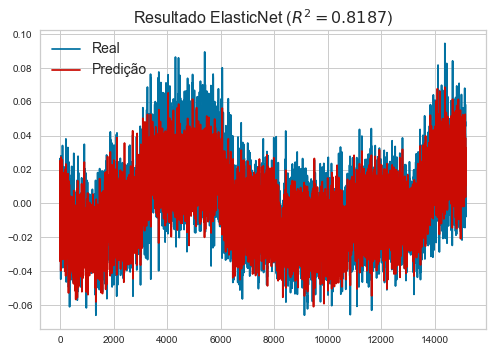

In [29]:
#Usando apenas ['CC_FL', 'CC_BL', 'AT_Y', 'AU_395_FR', 'AU_395_FL', 'AT_X', 'AT_Z']
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2=0.8187$)',size=16)
plt.legend(fontsize=14)

In [30]:
#residuals = real - predito

## Suport Vector Machine (SVM)

In [31]:
from sklearn.svm import SVR

def objective(trial):
    
        
    sv_gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.001)
    sv_C= trial.suggest_float("C", low=0.001, high=100,step=0.05)
    sv_epsilon= trial.suggest_float("epsilon", low=0.001, high=1,step=0.01)
    
    #sv_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model = SVR(gamma=sv_gamma,C=sv_C,epsilon=sv_epsilon)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_svm = optuna.create_study(direction='maximize')

In [32]:
#study_svm.optimize(objective, n_trials=20,show_progress_bar=True)

#trial = study_svm.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [33]:
#joblib.dump(study_svm, "study_SVM.pkl")

### AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=300, high=1000, step=25)
    h_learning_rate = trial.suggest_float("learning_rate", 0.1, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-05 20:39:25,428] A new study created in memory with name: no-name-b9d639a4-fc4f-4f5d-8a12-90cb7db7a889


In [35]:
study_ab.optimize(objective, n_trials=25)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-12-05 20:40:10,762] Trial 0 finished with value: 0.5276736273222722 and parameters: {'n_estimators': 825, 'learning_rate': 0.9738503284403197, 'loss': 'linear'}. Best is trial 0 with value: 0.5276736273222722.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2022-12-05 20:41:02,723] Trial 1 finished with value: 0.5335209432979089 and parameters: {'n_estimators': 725, 'learning_rate': 0.33647381878222965, 'loss': 'exponential'}. Best is trial 1 with value: 0.5335209432979089.
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\

Accuracy: 0.5889902584248514
Best hyperparameters: {'n_estimators': 375, 'learning_rate': 0.9604628757183389, 'loss': 'square'}


In [36]:
joblib.dump(study_ab, "study_AdaBost_FL.pkl")

['study_AdaBost_FL.pkl']

In [37]:
optuna.visualization.plot_optimization_history(study_ab)

In [38]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [39]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-05 20:53:12,205] A new study created in memory with name: no-name-f13eb4a6-5526-4264-bebf-155a4d717d56


In [49]:
study_xgbr.optimize(objective, n_trials=10,show_progress_bar=True)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 21:30:39,318] Trial 10 finished with value: 0.6629910164177086 and parameters: {'lambda': 0.5047249057045539, 'alpha': 0.0011663133698456222, 'colsample_bytree': 0.5, 'subsample': 1.0, 'n_estimators': 800, 'max_depth': 20, 'min_split_loss': 0.0013803427481796325, 'min_child_weight': 9.6, 'colsample_bylevel': 0.4, 'colsample_bynode': 0.3}. Best is trial 6 with value: 0.6836069292436199.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 21:31:36,533] Trial 11 finished with value: 0.6690103958198405 and parameters: {'lambda': 0.2853323095966919, 'alpha': 0.0043386271202248685, 'colsample_bytree': 0.5, 'subsample': 1.0, 'n_estimators': 500, 'max_depth': 20, 'min_split_loss': 0.0011343790680453918, 'min_child_weight': 9.1, 'colsample_bylevel': 0.4, 'colsample_bynode': 0.3}. Best is trial 6 with value: 0.6836069292436199.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



[I 2022-12-05 21:32:02,369] Trial 12 finished with value: 0.6993991060953251 and parameters: {'lambda': 0.13703512686834468, 'alpha': 0.0025164601740482917, 'colsample_bytree': 0.6000000000000001, 'subsample': 1.0, 'n_estimators': 550, 'max_depth': 8, 'min_split_loss': 0.00295215062515834, 'min_child_weight': 7.6, 'colsample_bylevel': 0.5, 'colsample_bynode': 0.3}. Best is trial 12 with value: 0.6993991060953251.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\distributions.py:668: UserWarning:

The distribution is specified by [0.1, 10] and step=0.5, but the range is not divisible by `step`. It will be replaced by [0.1, 9.6].



In [41]:
joblib.dump(study_xgbr, "study_XGBoost_FL.pkl")

['study_XGBoost_FL.pkl']

In [42]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [43]:
optuna.visualization.plot_slice(study_xgbr)

In [44]:
#study = joblib.load("study_XGBoost.pkl")
#print("Best trial until now:")
#print(" Value: ", study.best_trial.value)
#print(" Params: ",study.best_params)

In [45]:
#import xgboost as xgb
#mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
#mdl.fit(X_train_scaled,y_train)
#p=mdl.predict(X_test_scaled)
#score= mean_squared_error(y_test,p)
#score_r2 = r2_score(y_test,p)
#print("RMSE: ", score)
#print("R2: ", score_r2)

In [46]:
#predito_XGB = np.array(p,dtype=float)
#real= np.array(y_test,dtype=float)


In [47]:
#residuals = real - predito

In [48]:
JLJLHHHJAJÇLÇLKÇLAKDÇ

NameError: name 'JLJLHHHJAJÇLÇLKÇLAKDÇ' is not defined

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

Text(0.5, 1.0, 'Resultado XGBoost $R^2$ = 0.7740')

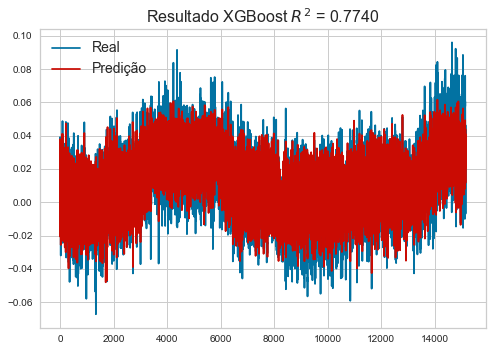

In [ ]:
plt.plot(real,'b',label='Real')
plt.plot(predito_XGB,'r',label = 'Predição')
plt.legend(fontsize=14)
plt.title('Resultado XGBoost $R^2$ = 0.7740',size=16)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

In [ ]:
predicted_XGB = pd.DataFrame(p, columns = ['L/V_FR'])
predicted_XGB.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real.csv', index=False)

# Learning Curve

In [ ]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
#model = ElasticNet(**study_en.best_params,random_state=2020)
#visualizer = LearningCurve(model, scoring='r2')

#visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

<Figure size 864x432 with 0 Axes>

# Real intrumantation IRV

In [ ]:
X_IRV, y_IRV = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_BL']]
X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV = create_scaled_dataset(X_IRV,y_IRV)

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=36, max_features=5, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=375,
                      random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000

 17%|█▋        | 1/6 [00:00<00:00,  7.65it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\1229660262.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 50%|█████     | 3/6 [10:39<13:57, 279.20s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [11:02<05:55, 177.84s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\1229660262.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

100%|██████████| 6/6 [11:12<00:00, 112.03s/it]
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



CPU times: total: 30min 58s
Wall time: 11min 17s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

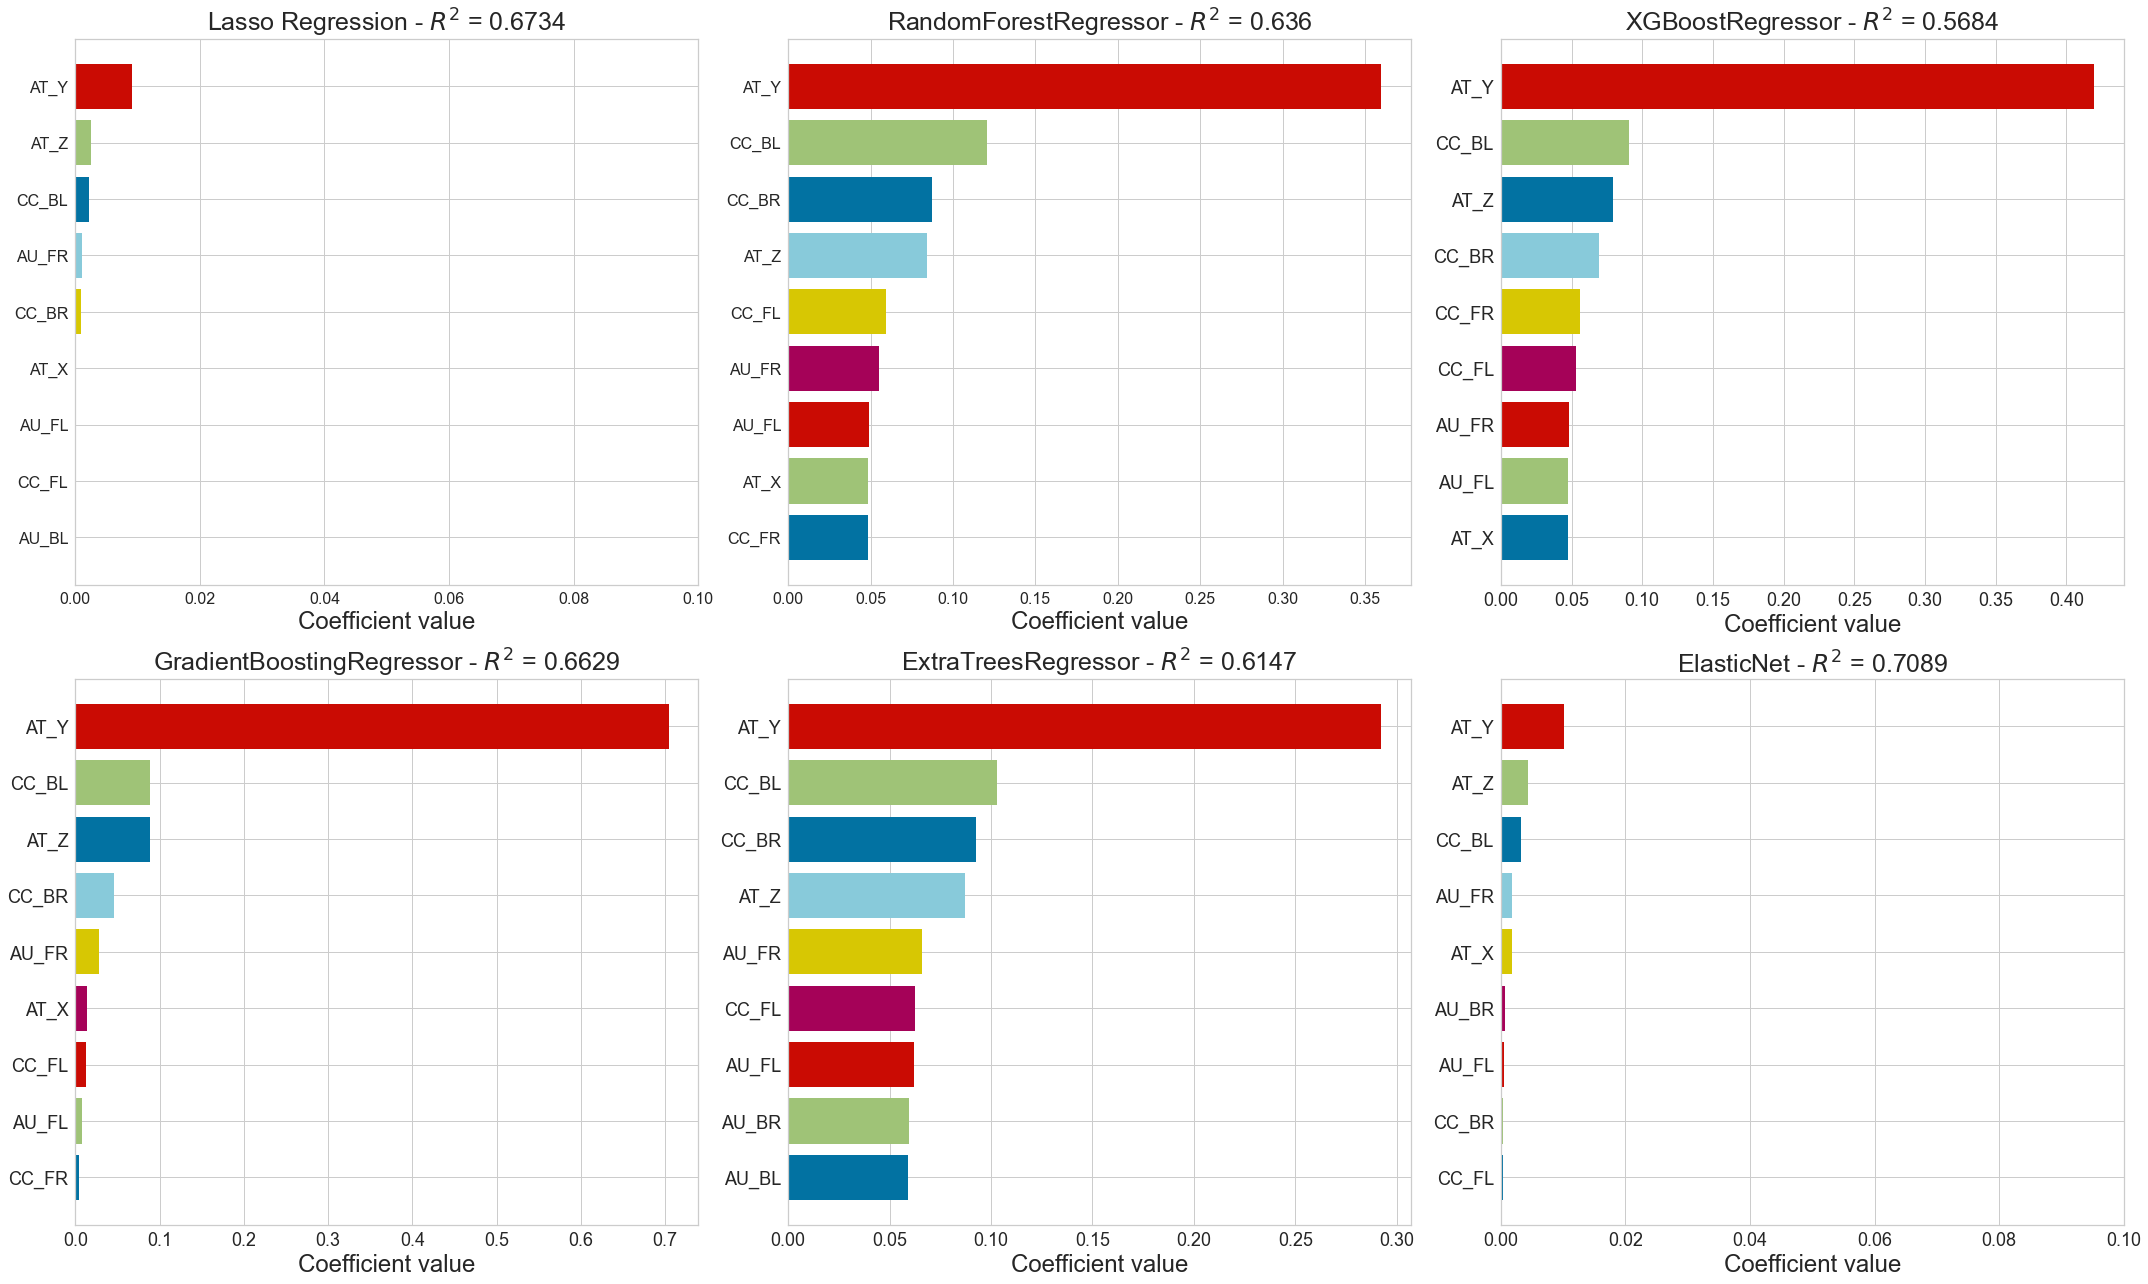

In [ ]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

In [ ]:
X_IRV, y_IRV2 = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_BR']]
X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2 = create_scaled_dataset(X_IRV,y_IRV2)

In [ ]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=11):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(random_state=0)
        mod5 = ExtraTreesRegressor(random_state=0, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=11, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=36, max_features=5, min_samples_leaf=5,
                      min_samples_split=11, n_estimators=375,
                      random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000

 17%|█▋        | 1/6 [00:00<00:00,  9.47it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 50%|█████     | 3/6 [13:19<17:03, 341.27s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [13:47<07:15, 217.65s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_9012\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

100%|██████████| 6/6 [13:58<00:00, 139.82s/it]
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature na

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%
Obtaining feature importance - 100%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



CPU times: total: 32min 11s
Wall time: 14min 1s


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

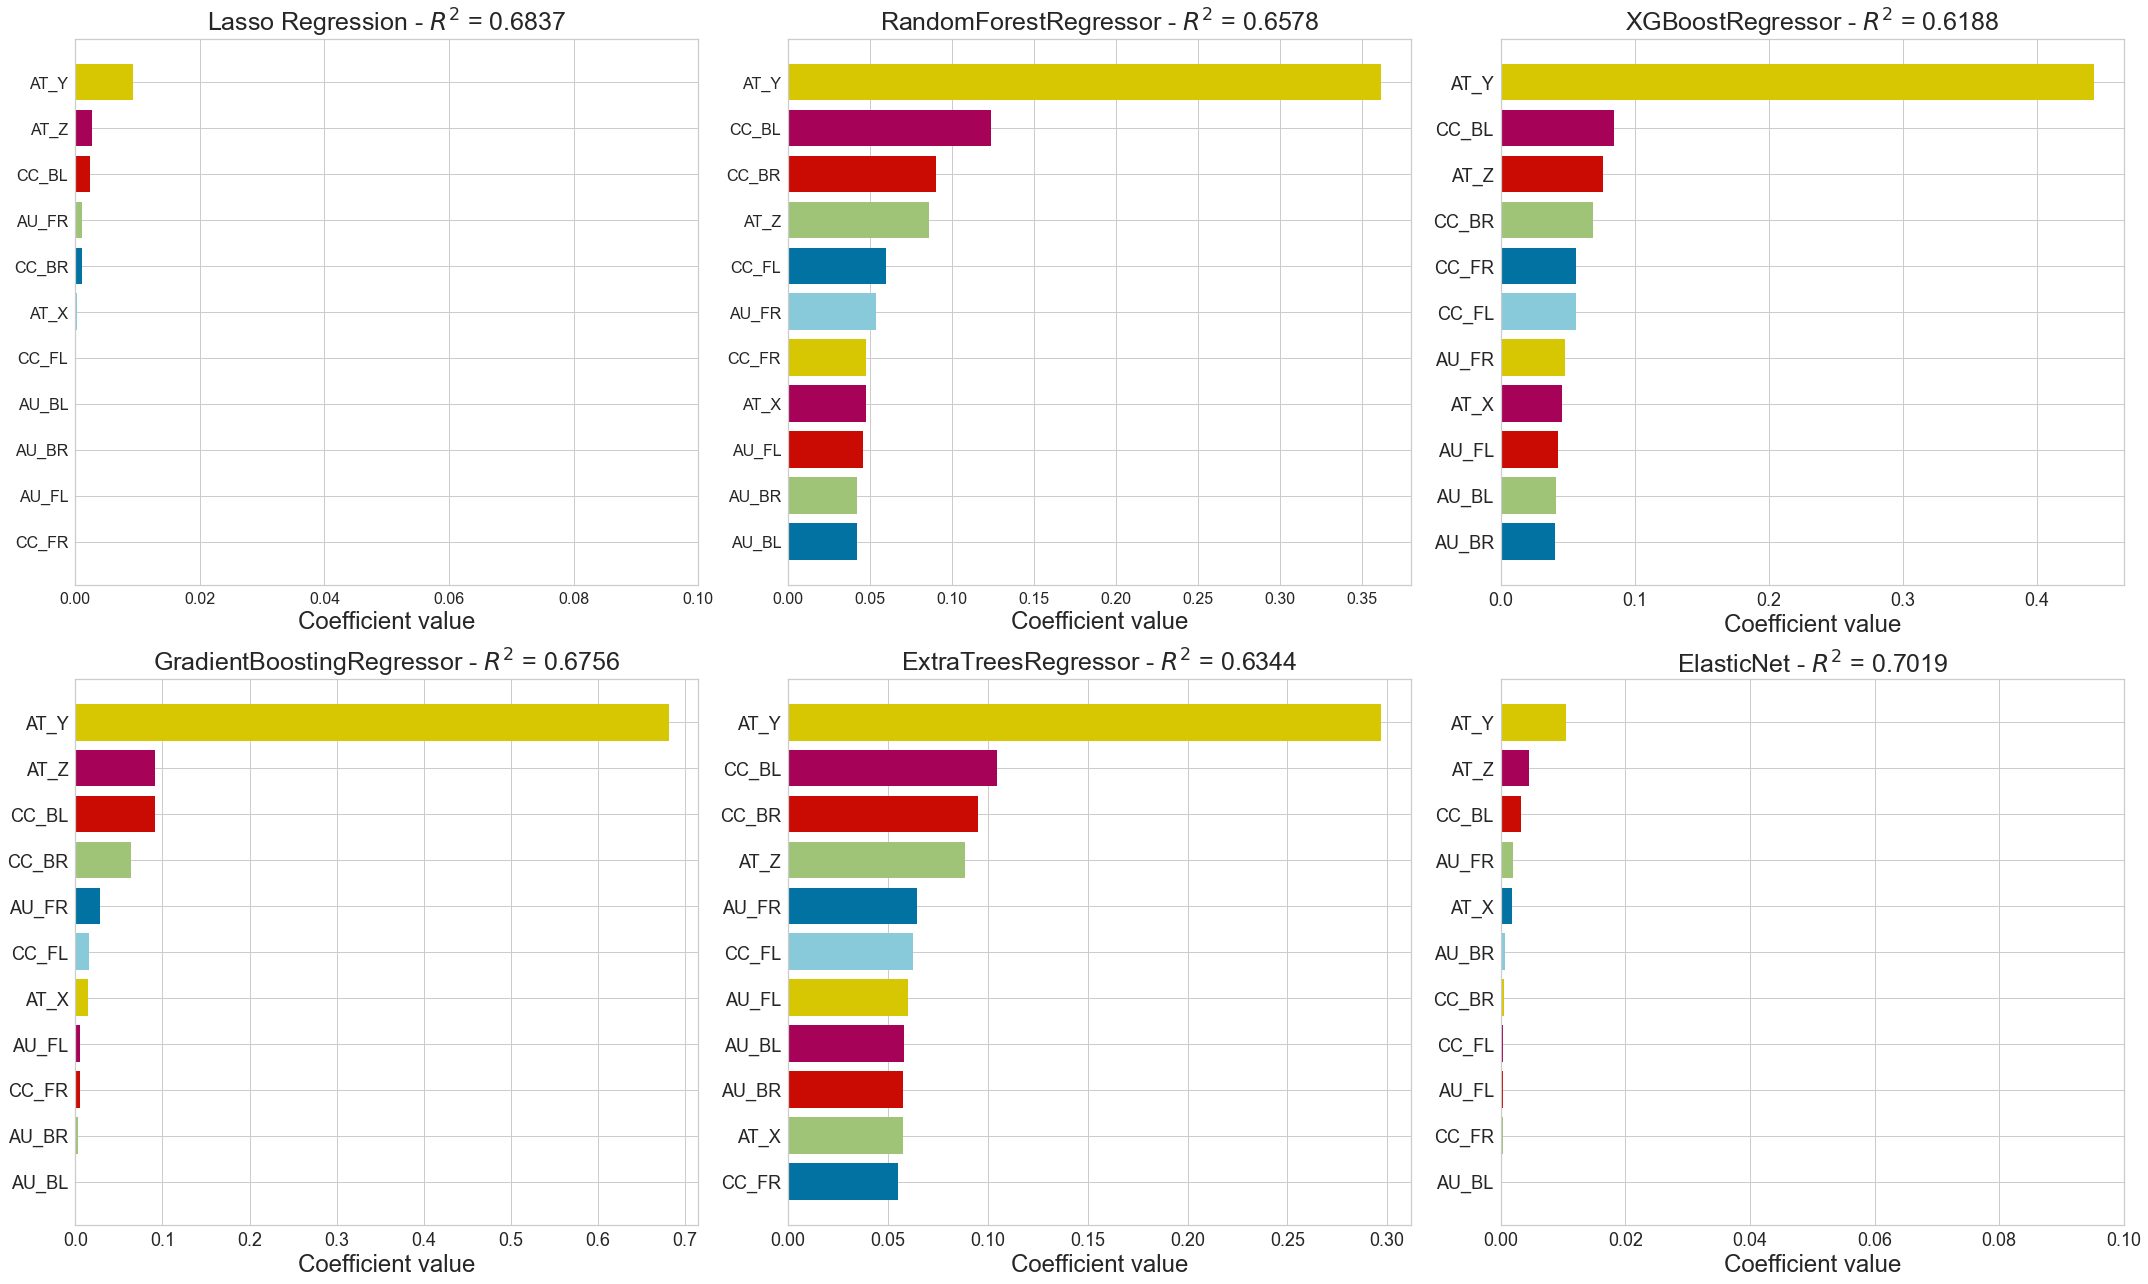

In [ ]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=32, max_features=6, min_samples_leaf=6,
                      min_samples_split=4, n_estimators=330, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

 33%|███▎      | 2/6 [01:25<02:51, 42.94s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

 50%|█████     | 3/6 [09:30<11:20, 226.97s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

 67%|██████▋   | 4/6 [09:51<05:00, 150.22s/it]C:\Users\DELL\AppData\Local\Temp\ipykernel_6004\452399402.py:150: DataConversionWarning:

A column-vector y was passed when 

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but ElasticNet was fitted with feature names



Obtaining feature importance - 100%
CPU times: total: 30min 19s
Wall time: 10min 1s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

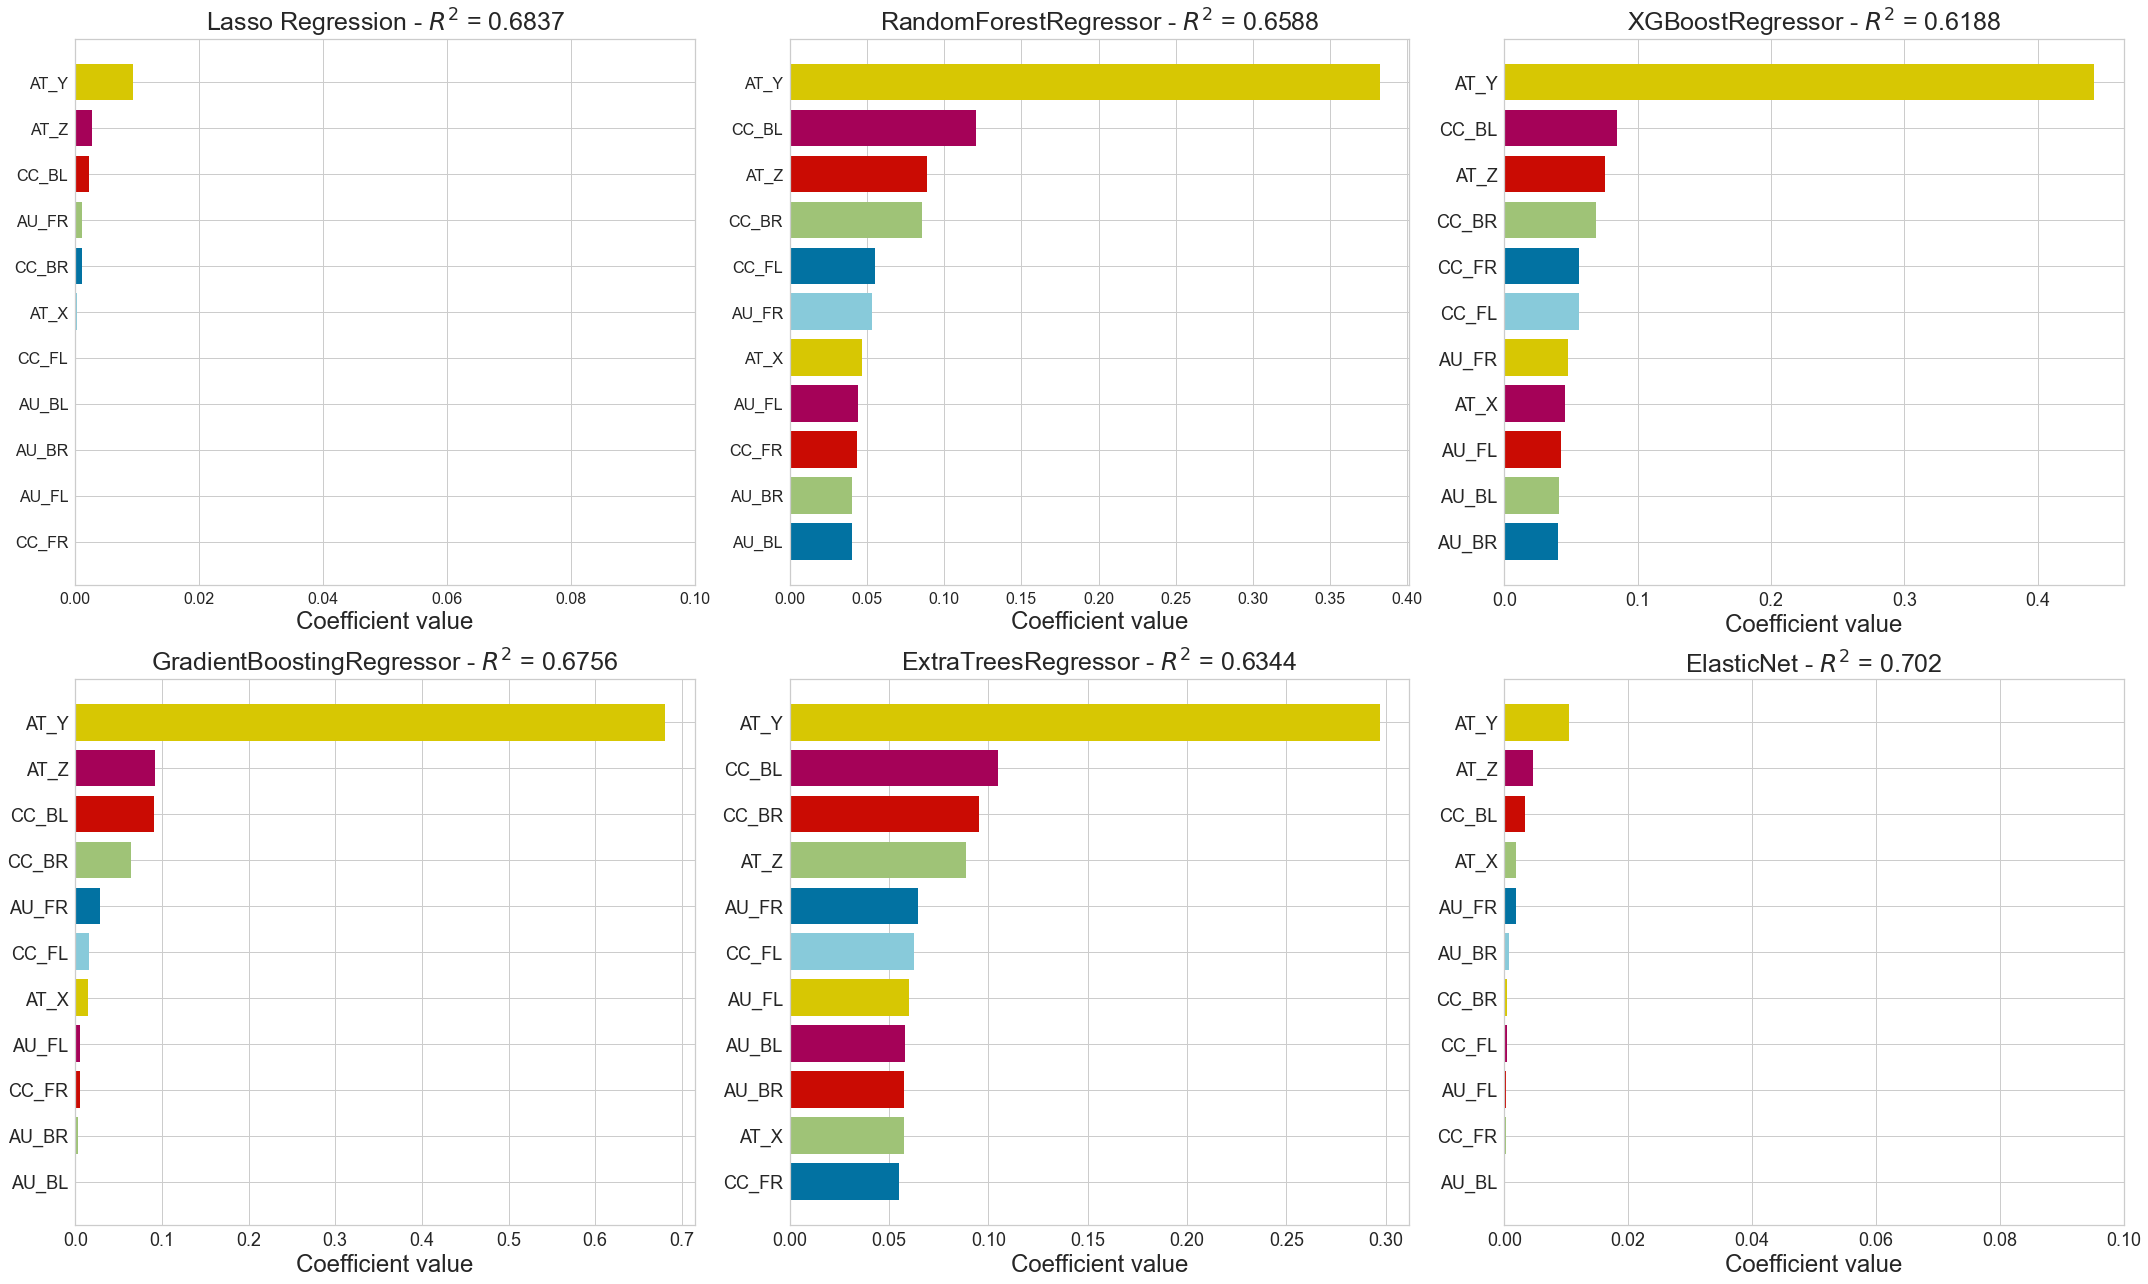

In [ ]:
%%time
multi_select = multivariate_importance(X_train_IRV,X_test_IRV,y_train_IRV2,y_test_IRV2)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')